# Problem 10.2

**Problem 10.2. Capacity and dispatch optimization in a network with a CO2 constraint.**

**We build on Problem 10.1 (d), i.e. we optimise F endogenously.**

**For (a)-(c), always calculate the following values:** 
 - **Total system costs (in bn EUR)**
 - **Average electricity price (in EUR/MWh); number/share of hours with a price below 2 EUR/MWh**
 - **Congestion rent**
 - **Utilisation of transmission lines (in % of cap.)**
 - **Total generation per technology (in TWh)**
 - **CO2 price (in EUR/tCO2)**

 **a) Set up a network as in 10.1d) and add a CO2 constraint of 2.5 MtCO2/year.**

 **b) The load distribution between Denmark and Portugal is approx. 1:1.5. Assume that both countries have national targets of 1 MtCO2/year and 1.5 MtCO2/year.**

 **c) Assume the CO2 limits from b, but that the transmission capacities is limited to 1 GW (still endougenously optimised).**

 **d) Change the global CO2 limit to 0.25, 0.5, 1, 1.5, 2 MtCO2/year, and plot the total system costs against the CO2 limit.**









In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [2]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [3]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]
costs.at["CCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [4]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [5]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [6]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [7]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [8]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onshore wind, solar and OCGT

In [9]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

np.float64(101644.12332388277)

In [10]:
costs.at["solar", "capital_cost"] #EUR/MW/a

np.float64(51346.82981964593)

In [11]:
costs.at["OCGT", "capital_cost"] #EUR/MW/a

np.float64(47718.67056370105)

In [12]:
costs.at["OCGT", "marginal_cost"] #EUR/MWh

np.float64(64.6839512195122)

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [13]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [14]:
data_solar.head()

,utc_time,AUT,BEL,BGR,BIH,CHE,CYP,CZE,DEU,DNK,...,MLT,NLD,NOR,POL,PRT,ROU,SRB,SVK,SVN,SWE
utc_time,,,,,,,,,,,,,,,,,,,,,
1979-01-01 00:00:00+00:00,1979-01-01T00:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 01:00:00+00:00,1979-01-01T01:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 02:00:00+00:00,1979-01-01T02:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 03:00:00+00:00,1979-01-01T03:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1979-01-01 04:00:00+00:00,1979-01-01T04:00:00Z,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We will use timeseries for Portugal and Denmark in this excercise

In [15]:
countries = ['PRT', 'DNK']
coordinates = {'PRT': (38.74, -9.15), 'DNK': (55.67, 12.57)}

# a. Add CO2 constraint, F endogenous.

For building the model, we start again by initialising an empty network, adding the snapshots, and the electricity bus.

In [16]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          v_nom = 400,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )


/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dt

In [17]:
carriers = [
    "onwind",
    "solar",
    "OCGT",
    "battery storage",
]

n.madd(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)

Index(['onwind', 'solar', 'OCGT', 'battery storage'], dtype='object')

In [18]:
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")

In [19]:
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

In [20]:
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
    capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
    s_nom_extendable = True,
)

In [21]:
n.add(
    "GlobalConstraint",
    "CO2Limit",
    carrier_attribute="co2_emissions",
    sense="<=",
    constant=2500000, #2.5MtCO2
)

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


(<matplotlib.collections.PatchCollection at 0x17e1c9ca0>,
 <matplotlib.collections.LineCollection at 0x302cbdb80>)

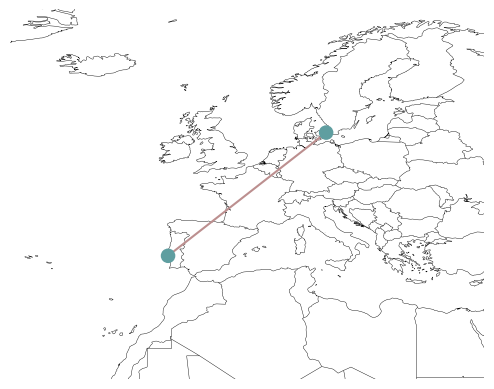

In [22]:
n.plot(bus_sizes=1, margin=1)

In [23]:
n.optimize(solver_name="gurobi")

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 89.53it/s]
INFO:linopy.io: Writing time: 0.38s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-b4mdo5r1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-b4mdo5r1.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


Model fingerprint: 0x8e828acd


INFO:gurobipy:Model fingerprint: 0x8e828acd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.26765238e+11  0.00000000e+00  3.15e+09 0.00e+00  2.37e+08     0s


INFO:gurobipy:   0   5.26765238e+11  0.00000000e+00  3.15e+09 0.00e+00  2.37e+08     0s


   1   6.10890823e+11 -9.68985986e+10  6.22e+08 2.23e+02  5.77e+07     0s


INFO:gurobipy:   1   6.10890823e+11 -9.68985986e+10  6.22e+08 2.23e+02  5.77e+07     0s


   2   4.48041353e+11 -1.16553990e+11  2.10e+07 2.18e+00  4.69e+06     0s


INFO:gurobipy:   2   4.48041353e+11 -1.16553990e+11  2.10e+07 2.18e+00  4.69e+06     0s


   3   7.65399378e+10 -4.00780552e+10  2.31e+06 2.20e-01  8.36e+05     0s


INFO:gurobipy:   3   7.65399378e+10 -4.00780552e+10  2.31e+06 2.20e-01  8.36e+05     0s


   4   4.80401967e+10 -2.02946431e+10  1.33e+06 5.82e-10  4.79e+05     0s


INFO:gurobipy:   4   4.80401967e+10 -2.02946431e+10  1.33e+06 5.82e-10  4.79e+05     0s


   5   3.30337282e+10 -1.48679559e+10  8.43e+05 1.14e-09  3.32e+05     0s


INFO:gurobipy:   5   3.30337282e+10 -1.48679559e+10  8.43e+05 1.14e-09  3.32e+05     0s


   6   2.62029598e+10 -1.03994074e+10  6.24e+05 6.98e-10  2.52e+05     0s


INFO:gurobipy:   6   2.62029598e+10 -1.03994074e+10  6.24e+05 6.98e-10  2.52e+05     0s


   7   1.86494975e+10 -4.85299148e+09  3.87e+05 1.16e-10  1.61e+05     0s


INFO:gurobipy:   7   1.86494975e+10 -4.85299148e+09  3.87e+05 1.16e-10  1.61e+05     0s


   8   1.45438364e+10 -1.29932145e+09  2.68e+05 3.78e-10  1.08e+05     0s


INFO:gurobipy:   8   1.45438364e+10 -1.29932145e+09  2.68e+05 3.78e-10  1.08e+05     0s


   9   1.38103617e+10 -7.49157545e+08  2.43e+05 4.66e-10  9.93e+04     0s


INFO:gurobipy:   9   1.38103617e+10 -7.49157545e+08  2.43e+05 4.66e-10  9.93e+04     0s


  10   1.32724454e+10  4.39294294e+08  2.23e+05 4.37e-11  8.75e+04     0s


INFO:gurobipy:  10   1.32724454e+10  4.39294294e+08  2.23e+05 4.37e-11  8.75e+04     0s


  11   1.12681179e+10  2.45514877e+09  1.62e+05 1.25e-09  6.00e+04     0s


INFO:gurobipy:  11   1.12681179e+10  2.45514877e+09  1.62e+05 1.25e-09  6.00e+04     0s


  12   1.09140516e+10  2.92356088e+09  1.51e+05 6.40e-10  5.44e+04     0s


INFO:gurobipy:  12   1.09140516e+10  2.92356088e+09  1.51e+05 6.40e-10  5.44e+04     0s


  13   1.04382174e+10  3.30912657e+09  1.36e+05 6.40e-10  4.85e+04     0s


INFO:gurobipy:  13   1.04382174e+10  3.30912657e+09  1.36e+05 6.40e-10  4.85e+04     0s


  14   1.01625762e+10  3.56596622e+09  1.25e+05 2.62e-10  4.49e+04     0s


INFO:gurobipy:  14   1.01625762e+10  3.56596622e+09  1.25e+05 2.62e-10  4.49e+04     0s


  15   9.52948858e+09  4.21270707e+09  1.02e+05 8.73e-11  3.62e+04     0s


INFO:gurobipy:  15   9.52948858e+09  4.21270707e+09  1.02e+05 8.73e-11  3.62e+04     0s


  16   9.26362538e+09  4.95394175e+09  8.98e+04 4.73e-11  2.93e+04     0s


INFO:gurobipy:  16   9.26362538e+09  4.95394175e+09  8.98e+04 4.73e-11  2.93e+04     0s


  17   9.13196092e+09  5.22918629e+09  8.39e+04 5.82e-11  2.66e+04     0s


INFO:gurobipy:  17   9.13196092e+09  5.22918629e+09  8.39e+04 5.82e-11  2.66e+04     0s


  18   8.82313808e+09  5.41896103e+09  6.84e+04 6.55e-11  2.32e+04     0s


INFO:gurobipy:  18   8.82313808e+09  5.41896103e+09  6.84e+04 6.55e-11  2.32e+04     0s


  19   8.65924562e+09  5.55432626e+09  5.85e+04 1.46e-11  2.11e+04     0s


INFO:gurobipy:  19   8.65924562e+09  5.55432626e+09  5.85e+04 1.46e-11  2.11e+04     0s


  20   8.49397810e+09  6.07105532e+09  4.87e+04 2.62e-10  1.65e+04     0s


INFO:gurobipy:  20   8.49397810e+09  6.07105532e+09  4.87e+04 2.62e-10  1.65e+04     0s


  21   8.40323974e+09  6.20150879e+09  4.37e+04 1.27e-10  1.50e+04     0s


INFO:gurobipy:  21   8.40323974e+09  6.20150879e+09  4.37e+04 1.27e-10  1.50e+04     0s


  22   8.30222493e+09  6.31498984e+09  3.82e+04 5.82e-11  1.35e+04     1s


INFO:gurobipy:  22   8.30222493e+09  6.31498984e+09  3.82e+04 5.82e-11  1.35e+04     1s


  23   8.26649916e+09  6.38087684e+09  3.47e+04 9.60e-10  1.28e+04     1s


INFO:gurobipy:  23   8.26649916e+09  6.38087684e+09  3.47e+04 9.60e-10  1.28e+04     1s


  24   8.22390988e+09  6.54457323e+09  3.20e+04 2.33e-10  1.14e+04     1s


INFO:gurobipy:  24   8.22390988e+09  6.54457323e+09  3.20e+04 2.33e-10  1.14e+04     1s


  25   8.17599646e+09  6.64143869e+09  2.87e+04 6.55e-11  1.04e+04     1s


INFO:gurobipy:  25   8.17599646e+09  6.64143869e+09  2.87e+04 6.55e-11  1.04e+04     1s


  26   8.15739438e+09  6.76253791e+09  2.75e+04 7.64e-11  9.48e+03     1s


INFO:gurobipy:  26   8.15739438e+09  6.76253791e+09  2.75e+04 7.64e-11  9.48e+03     1s


  27   8.08927947e+09  6.86831869e+09  2.27e+04 3.78e-10  8.30e+03     1s


INFO:gurobipy:  27   8.08927947e+09  6.86831869e+09  2.27e+04 3.78e-10  8.30e+03     1s


  28   8.06594186e+09  6.92560759e+09  2.09e+04 1.02e-10  7.75e+03     1s


INFO:gurobipy:  28   8.06594186e+09  6.92560759e+09  2.09e+04 1.02e-10  7.75e+03     1s


  29   8.03682206e+09  7.00890060e+09  1.86e+04 6.40e-10  6.98e+03     1s


INFO:gurobipy:  29   8.03682206e+09  7.00890060e+09  1.86e+04 6.40e-10  6.98e+03     1s


  30   8.01985692e+09  7.05543158e+09  1.63e+04 3.78e-10  6.55e+03     1s


INFO:gurobipy:  30   8.01985692e+09  7.05543158e+09  1.63e+04 3.78e-10  6.55e+03     1s


  31   7.98958400e+09  7.12347378e+09  1.27e+04 3.06e-10  5.87e+03     1s


INFO:gurobipy:  31   7.98958400e+09  7.12347378e+09  1.27e+04 3.06e-10  5.87e+03     1s


  32   7.95874228e+09  7.23703262e+09  9.53e+03 3.78e-10  4.89e+03     1s


INFO:gurobipy:  32   7.95874228e+09  7.23703262e+09  9.53e+03 3.78e-10  4.89e+03     1s


  33   7.94493370e+09  7.30566823e+09  8.49e+03 1.46e-10  4.33e+03     1s


INFO:gurobipy:  33   7.94493370e+09  7.30566823e+09  8.49e+03 1.46e-10  4.33e+03     1s


  34   7.93608045e+09  7.34715630e+09  7.85e+03 1.75e-10  3.99e+03     1s


INFO:gurobipy:  34   7.93608045e+09  7.34715630e+09  7.85e+03 1.75e-10  3.99e+03     1s


  35   7.93262307e+09  7.36521865e+09  7.57e+03 5.82e-11  3.84e+03     1s


INFO:gurobipy:  35   7.93262307e+09  7.36521865e+09  7.57e+03 5.82e-11  3.84e+03     1s


  36   7.92080215e+09  7.44398679e+09  6.57e+03 1.16e-10  3.23e+03     1s


INFO:gurobipy:  36   7.92080215e+09  7.44398679e+09  6.57e+03 1.16e-10  3.23e+03     1s


  37   7.91375401e+09  7.49836397e+09  5.99e+03 8.44e-10  2.82e+03     1s


INFO:gurobipy:  37   7.91375401e+09  7.49836397e+09  5.99e+03 8.44e-10  2.82e+03     1s


  38   7.90702779e+09  7.52027692e+09  5.41e+03 7.82e-11  2.62e+03     1s


INFO:gurobipy:  38   7.90702779e+09  7.52027692e+09  5.41e+03 7.82e-11  2.62e+03     1s


  39   7.89625964e+09  7.53904525e+09  4.35e+03 2.91e-10  2.42e+03     1s


INFO:gurobipy:  39   7.89625964e+09  7.53904525e+09  4.35e+03 2.91e-10  2.42e+03     1s


  40   7.89085528e+09  7.56984710e+09  3.77e+03 3.20e-10  2.17e+03     1s


INFO:gurobipy:  40   7.89085528e+09  7.56984710e+09  3.77e+03 3.20e-10  2.17e+03     1s


  41   7.88092338e+09  7.59963959e+09  2.71e+03 1.05e-09  1.90e+03     1s


INFO:gurobipy:  41   7.88092338e+09  7.59963959e+09  2.71e+03 1.05e-09  1.90e+03     1s


  42   7.87711235e+09  7.61841939e+09  2.39e+03 5.09e-11  1.75e+03     1s


INFO:gurobipy:  42   7.87711235e+09  7.61841939e+09  2.39e+03 5.09e-11  1.75e+03     1s


  43   7.87497999e+09  7.63676343e+09  2.14e+03 3.64e-10  1.61e+03     1s


INFO:gurobipy:  43   7.87497999e+09  7.63676343e+09  2.14e+03 3.64e-10  1.61e+03     1s


  44   7.86928599e+09  7.67162185e+09  1.70e+03 2.62e-10  1.34e+03     1s


INFO:gurobipy:  44   7.86928599e+09  7.67162185e+09  1.70e+03 2.62e-10  1.34e+03     1s


  45   7.86489633e+09  7.68666057e+09  1.23e+03 5.24e-10  1.20e+03     1s


INFO:gurobipy:  45   7.86489633e+09  7.68666057e+09  1.23e+03 5.24e-10  1.20e+03     1s


  46   7.86220525e+09  7.71691853e+09  9.96e+02 6.40e-10  9.80e+02     1s


INFO:gurobipy:  46   7.86220525e+09  7.71691853e+09  9.96e+02 6.40e-10  9.80e+02     1s


  47   7.86006126e+09  7.73064874e+09  8.39e+02 3.49e-10  8.73e+02     1s


INFO:gurobipy:  47   7.86006126e+09  7.73064874e+09  8.39e+02 3.49e-10  8.73e+02     1s


  48   7.85885829e+09  7.73425401e+09  7.54e+02 7.86e-10  8.40e+02     1s


INFO:gurobipy:  48   7.85885829e+09  7.73425401e+09  7.54e+02 7.86e-10  8.40e+02     1s


  49   7.85690288e+09  7.74659345e+09  5.95e+02 1.46e-10  7.44e+02     1s


INFO:gurobipy:  49   7.85690288e+09  7.74659345e+09  5.95e+02 1.46e-10  7.44e+02     1s


  50   7.85650366e+09  7.75278174e+09  5.64e+02 1.16e-10  6.99e+02     1s


INFO:gurobipy:  50   7.85650366e+09  7.75278174e+09  5.64e+02 1.16e-10  6.99e+02     1s


  51   7.85572912e+09  7.76315051e+09  5.13e+02 6.98e-10  6.24e+02     1s


INFO:gurobipy:  51   7.85572912e+09  7.76315051e+09  5.13e+02 6.98e-10  6.24e+02     1s


  52   7.85485409e+09  7.77093108e+09  4.53e+02 1.32e-09  5.66e+02     1s


INFO:gurobipy:  52   7.85485409e+09  7.77093108e+09  4.53e+02 1.32e-09  5.66e+02     1s


  53   7.85433308e+09  7.77287997e+09  4.09e+02 1.12e-09  5.49e+02     1s


INFO:gurobipy:  53   7.85433308e+09  7.77287997e+09  4.09e+02 1.12e-09  5.49e+02     1s


  54   7.85345680e+09  7.78280902e+09  3.49e+02 2.75e-09  4.76e+02     1s


INFO:gurobipy:  54   7.85345680e+09  7.78280902e+09  3.49e+02 2.75e-09  4.76e+02     1s


  55   7.85283403e+09  7.79826291e+09  3.13e+02 9.63e-09  3.68e+02     1s


INFO:gurobipy:  55   7.85283403e+09  7.79826291e+09  3.13e+02 9.63e-09  3.68e+02     1s


  56   7.85233479e+09  7.79999159e+09  2.79e+02 9.27e-09  3.53e+02     1s


INFO:gurobipy:  56   7.85233479e+09  7.79999159e+09  2.79e+02 9.27e-09  3.53e+02     1s


  57   7.85174784e+09  7.80447595e+09  2.41e+02 1.19e-08  3.19e+02     1s


INFO:gurobipy:  57   7.85174784e+09  7.80447595e+09  2.41e+02 1.19e-08  3.19e+02     1s


  58   7.85120949e+09  7.80819345e+09  2.11e+02 1.22e-08  2.90e+02     1s


INFO:gurobipy:  58   7.85120949e+09  7.80819345e+09  2.11e+02 1.22e-08  2.90e+02     1s


  59   7.85073764e+09  7.81145437e+09  1.83e+02 1.23e-08  2.65e+02     1s


INFO:gurobipy:  59   7.85073764e+09  7.81145437e+09  1.83e+02 1.23e-08  2.65e+02     1s


  60   7.85053184e+09  7.81173190e+09  1.74e+02 1.24e-08  2.61e+02     1s


INFO:gurobipy:  60   7.85053184e+09  7.81173190e+09  1.74e+02 1.24e-08  2.61e+02     1s


  61   7.85034902e+09  7.81970655e+09  1.67e+02 1.75e-08  2.07e+02     1s


INFO:gurobipy:  61   7.85034902e+09  7.81970655e+09  1.67e+02 1.75e-08  2.07e+02     1s


  62   7.84999296e+09  7.82542908e+09  1.49e+02 1.78e-08  1.66e+02     1s


INFO:gurobipy:  62   7.84999296e+09  7.82542908e+09  1.49e+02 1.78e-08  1.66e+02     1s


  63   7.84922994e+09  7.82726197e+09  9.53e+01 1.64e-08  1.48e+02     1s


INFO:gurobipy:  63   7.84922994e+09  7.82726197e+09  9.53e+01 1.64e-08  1.48e+02     1s


  64   7.84896730e+09  7.82818824e+09  8.37e+01 1.60e-08  1.40e+02     1s


INFO:gurobipy:  64   7.84896730e+09  7.82818824e+09  8.37e+01 1.60e-08  1.40e+02     1s


  65   7.84889370e+09  7.82972710e+09  7.74e+01 1.49e-08  1.29e+02     1s


INFO:gurobipy:  65   7.84889370e+09  7.82972710e+09  7.74e+01 1.49e-08  1.29e+02     1s


  66   7.84859002e+09  7.83150269e+09  6.40e+01 1.30e-08  1.15e+02     1s


INFO:gurobipy:  66   7.84859002e+09  7.83150269e+09  6.40e+01 1.30e-08  1.15e+02     1s


  67   7.84833143e+09  7.83206162e+09  5.37e+01 1.28e-08  1.10e+02     1s


INFO:gurobipy:  67   7.84833143e+09  7.83206162e+09  5.37e+01 1.28e-08  1.10e+02     1s


  68   7.84821039e+09  7.83244057e+09  4.34e+01 1.23e-08  1.06e+02     1s


INFO:gurobipy:  68   7.84821039e+09  7.83244057e+09  4.34e+01 1.23e-08  1.06e+02     1s


  69   7.84793974e+09  7.83385912e+09  3.30e+01 1.16e-08  9.48e+01     1s


INFO:gurobipy:  69   7.84793974e+09  7.83385912e+09  3.30e+01 1.16e-08  9.48e+01     1s


  70   7.84782254e+09  7.83516048e+09  2.84e+01 1.55e-08  8.52e+01     1s


INFO:gurobipy:  70   7.84782254e+09  7.83516048e+09  2.84e+01 1.55e-08  8.52e+01     1s


  71   7.84748798e+09  7.83762059e+09  1.24e+01 1.13e-08  6.64e+01     1s


INFO:gurobipy:  71   7.84748798e+09  7.83762059e+09  1.24e+01 1.13e-08  6.64e+01     1s


  72   7.84728046e+09  7.84240527e+09  8.11e-01 4.85e-09  3.28e+01     1s


INFO:gurobipy:  72   7.84728046e+09  7.84240527e+09  8.11e-01 4.85e-09  3.28e+01     1s


  73   7.84719457e+09  7.84266131e+09  3.06e-01 4.86e-09  3.05e+01     1s


INFO:gurobipy:  73   7.84719457e+09  7.84266131e+09  3.06e-01 4.86e-09  3.05e+01     1s


  74   7.84719059e+09  7.84322941e+09  2.84e-01 4.29e-09  2.66e+01     1s


INFO:gurobipy:  74   7.84719059e+09  7.84322941e+09  2.84e-01 4.29e-09  2.66e+01     1s


  75   7.84713853e+09  7.84509838e+09  3.51e-02 2.24e-09  1.37e+01     1s


INFO:gurobipy:  75   7.84713853e+09  7.84509838e+09  3.51e-02 2.24e-09  1.37e+01     1s


  76   7.84710830e+09  7.84521821e+09  9.60e-03 1.94e-09  1.27e+01     1s


INFO:gurobipy:  76   7.84710830e+09  7.84521821e+09  9.60e-03 1.94e-09  1.27e+01     1s


  77   7.84710511e+09  7.84563406e+09  4.57e-05 1.39e-09  9.89e+00     1s


INFO:gurobipy:  77   7.84710511e+09  7.84563406e+09  4.57e-05 1.39e-09  9.89e+00     1s


  78   7.84710756e+09  7.84698801e+09  3.43e-05 2.82e-09  8.03e-01     1s


INFO:gurobipy:  78   7.84710756e+09  7.84698801e+09  3.43e-05 2.82e-09  8.03e-01     1s


  79   7.84709184e+09  7.84708332e+09  2.86e-06 1.25e-09  5.72e-02     1s


INFO:gurobipy:  79   7.84709184e+09  7.84708332e+09  2.86e-06 1.25e-09  5.72e-02     1s


  80   7.84709143e+09  7.84709142e+09  1.84e-10 5.13e-10  5.21e-05     1s


INFO:gurobipy:  80   7.84709143e+09  7.84709142e+09  1.84e-10 5.13e-10  5.21e-05     1s


  81   7.84709142e+09  7.84709142e+09  5.46e-07 1.69e-09  1.31e-10     1s


INFO:gurobipy:  81   7.84709142e+09  7.84709142e+09  5.46e-07 1.69e-09  1.31e-10     1s


INFO:gurobipy:


Barrier solved model in 81 iterations and 1.32 seconds (2.24 work units)


INFO:gurobipy:Barrier solved model in 81 iterations and 1.32 seconds (2.24 work units)


Optimal objective 7.84709142e+09


INFO:gurobipy:Optimal objective 7.84709142e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8563 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    8563 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9947344e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9947344e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8617    7.8470914e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8617    7.8470914e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8617 iterations and 1.68 seconds (3.61 work units)


INFO:gurobipy:Solved in 8617 iterations and 1.68 seconds (3.61 work units)


Optimal objective  7.847091424e+09


INFO:gurobipy:Optimal objective  7.847091424e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 7.85e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

('ok', 'optimal')

In [24]:
# Total system costs
n.objective/1e9

7.847091424204098

In [25]:
# Average electricity price
n.buses_t.marginal_price.mean()

Bus
PRT    126.774772
DNK    123.115762
dtype: float64

In [26]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

Bus
PRT    6803
DNK    6863
dtype: int64

In [27]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

Bus
PRT    0.776598
DNK    0.783447
dtype: float64

In [ ]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(127064788.5672172)

In [29]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

Line
PRT-DNK    0.629114
dtype: float64

In [30]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        4.3
     onwind     14.5
     solar       2.0
PRT  OCGT        0.9
     onwind     46.9
     solar      13.2
dtype: float64

In [31]:
n.generators.efficiency

Generator
PRT OCGT      0.41
PRT onwind    1.00
PRT solar     1.00
DNK OCGT      0.41
DNK onwind    1.00
DNK solar     1.00
Name: efficiency, dtype: float64

In [32]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(2500000.00000152)

In [33]:
# CO2 price
n.global_constraints

attribute,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
CO2Limit,primary_energy,NaN,co2_emissions,<=,2500000.0,-981.629031


# b. National CO2 limits, F endogenous.

In [34]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          v_nom = 400,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
    "battery storage",
]

n.madd(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
    capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
    s_nom_extendable = True,
)

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dt

In [35]:
n.optimize.create_model()
co2_emission_factor = (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])
n.model.add_constraints(
(n.model.variables["Generator-p"].sum("snapshot") * [co2_emission_factor,0,0,co2_emission_factor,0,0]).groupby(n.generators.bus.to_xarray()).sum(),
    "<=",
    [1000000,1500000],
    name="CO2Limit"
)

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)


Constraint `CO2Limit` (bus: 2):
-------------------------------
[DNK]: +0.4829 Generator-p[2015-01-01 00:00:00, DNK OCGT] + 0 Generator-p[2015-01-01 00:00:00, DNK onwind] + 0 Generator-p[2015-01-01 00:00:00, DNK solar] ... +0.4829 Generator-p[2015-12-31 23:00:00, DNK OCGT] + 0 Generator-p[2015-12-31 23:00:00, DNK onwind] + 0 Generator-p[2015-12-31 23:00:00, DNK solar] ≤ 1000000.0
[PRT]: +0.4829 Generator-p[2015-01-01 00:00:00, PRT OCGT] + 0 Generator-p[2015-01-01 00:00:00, PRT onwind] + 0 Generator-p[2015-01-01 00:00:00, PRT solar] ... +0.4829 Generator-p[2015-12-31 23:00:00, PRT OCGT] + 0 Generator-p[2015-12-31 23:00:00, PRT onwind] + 0 Generator-p[2015-12-31 23:00:00, PRT solar] ≤ 1500000.0

In [36]:
n.optimize.solve_model(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 88.43it/s]
INFO:linopy.io: Writing time: 0.39s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-ai9odwck.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-ai9odwck.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140169 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140169 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140169 rows, 61327 columns and 271592 nonzeros


INFO:gurobipy:Optimize a model with 140169 rows, 61327 columns and 271592 nonzeros


Model fingerprint: 0x8f4082ce


INFO:gurobipy:Model fingerprint: 0x8f4082ce


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 70107 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70107 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.270e+05


INFO:gurobipy: AA' NZ     : 2.270e+05


 Factor NZ  : 8.885e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.885e+05 (roughly 50 MB of memory)


 Factor Ops : 1.178e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.178e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.22687050e+11  0.00000000e+00  1.26e+09 0.00e+00  1.90e+08     0s


INFO:gurobipy:   0   4.22687050e+11  0.00000000e+00  1.26e+09 0.00e+00  1.90e+08     0s


   1   4.90288192e+11 -9.52973816e+10  2.47e+08 2.23e+02  4.62e+07     0s


INFO:gurobipy:   1   4.90288192e+11 -9.52973816e+10  2.47e+08 2.23e+02  4.62e+07     0s


   2   3.68025619e+11 -1.10031293e+11  1.35e+07 1.70e+00  4.16e+06     0s


INFO:gurobipy:   2   3.68025619e+11 -1.10031293e+11  1.35e+07 1.70e+00  4.16e+06     0s


   3   6.25070764e+10 -3.55890244e+10  1.49e+06 2.36e-09  7.15e+05     0s


INFO:gurobipy:   3   6.25070764e+10 -3.55890244e+10  1.49e+06 2.36e-09  7.15e+05     0s


   4   3.94367930e+10 -1.90579737e+10  8.61e+05 8.73e-10  4.16e+05     0s


INFO:gurobipy:   4   3.94367930e+10 -1.90579737e+10  8.61e+05 8.73e-10  4.16e+05     0s


   5   2.93408898e+10 -1.42914113e+10  5.95e+05 5.24e-10  3.07e+05     0s


INFO:gurobipy:   5   2.93408898e+10 -1.42914113e+10  5.95e+05 5.24e-10  3.07e+05     0s


   6   2.35119955e+10 -9.51457735e+09  4.41e+05 9.90e-10  2.30e+05     0s


INFO:gurobipy:   6   2.35119955e+10 -9.51457735e+09  4.41e+05 9.90e-10  2.30e+05     0s


   7   1.79605788e+10 -3.31826418e+09  3.00e+05 1.75e-10  1.47e+05     0s


INFO:gurobipy:   7   1.79605788e+10 -3.31826418e+09  3.00e+05 1.75e-10  1.47e+05     0s


   8   1.38816008e+10 -9.70796913e+07  1.99e+05 2.62e-10  9.61e+04     0s


INFO:gurobipy:   8   1.38816008e+10 -9.70796913e+07  1.99e+05 2.62e-10  9.61e+04     0s


   9   1.20573576e+10  7.52858379e+08  1.52e+05 1.60e-10  7.76e+04     0s


INFO:gurobipy:   9   1.20573576e+10  7.52858379e+08  1.52e+05 1.60e-10  7.76e+04     0s


  10   1.17211670e+10  1.16006953e+09  1.42e+05 4.66e-10  7.24e+04     0s


INFO:gurobipy:  10   1.17211670e+10  1.16006953e+09  1.42e+05 4.66e-10  7.24e+04     0s


  11   1.10283102e+10  3.12477349e+09  1.24e+05 9.60e-10  5.42e+04     0s


INFO:gurobipy:  11   1.10283102e+10  3.12477349e+09  1.24e+05 9.60e-10  5.42e+04     0s


  12   1.03576993e+10  4.10629529e+09  1.05e+05 1.16e-10  4.29e+04     0s


INFO:gurobipy:  12   1.03576993e+10  4.10629529e+09  1.05e+05 1.16e-10  4.29e+04     0s


  13   9.64387635e+09  4.74351205e+09  8.38e+04 3.20e-10  3.36e+04     0s


INFO:gurobipy:  13   9.64387635e+09  4.74351205e+09  8.38e+04 3.20e-10  3.36e+04     0s


  14   9.46687735e+09  5.07032132e+09  7.84e+04 9.31e-10  3.02e+04     0s


INFO:gurobipy:  14   9.46687735e+09  5.07032132e+09  7.84e+04 9.31e-10  3.02e+04     0s


  15   9.27846728e+09  5.59116180e+09  6.82e+04 2.33e-10  2.53e+04     0s


INFO:gurobipy:  15   9.27846728e+09  5.59116180e+09  6.82e+04 2.33e-10  2.53e+04     0s


  16   8.88778551e+09  5.82291364e+09  5.26e+04 9.31e-10  2.10e+04     0s


INFO:gurobipy:  16   8.88778551e+09  5.82291364e+09  5.26e+04 9.31e-10  2.10e+04     0s


  17   8.57481178e+09  6.00150203e+09  3.88e+04 5.82e-10  1.76e+04     0s


INFO:gurobipy:  17   8.57481178e+09  6.00150203e+09  3.88e+04 5.82e-10  1.76e+04     0s


  18   8.49108031e+09  6.12319302e+09  3.51e+04 4.95e-10  1.62e+04     0s


INFO:gurobipy:  18   8.49108031e+09  6.12319302e+09  3.51e+04 4.95e-10  1.62e+04     0s


  19   8.40165307e+09  6.24855400e+09  3.07e+04 3.20e-10  1.47e+04     0s


INFO:gurobipy:  19   8.40165307e+09  6.24855400e+09  3.07e+04 3.20e-10  1.47e+04     0s


  20   8.30562001e+09  6.61654176e+09  2.57e+04 2.62e-10  1.16e+04     0s


INFO:gurobipy:  20   8.30562001e+09  6.61654176e+09  2.57e+04 2.62e-10  1.16e+04     0s


  21   8.23620308e+09  6.69051639e+09  2.19e+04 8.44e-10  1.06e+04     1s


INFO:gurobipy:  21   8.23620308e+09  6.69051639e+09  2.19e+04 8.44e-10  1.06e+04     1s


  22   8.14246062e+09  7.00230551e+09  1.72e+04 4.07e-10  7.80e+03     1s


INFO:gurobipy:  22   8.14246062e+09  7.00230551e+09  1.72e+04 4.07e-10  7.80e+03     1s


  23   8.10863664e+09  7.09088892e+09  1.55e+04 9.31e-10  6.96e+03     1s


INFO:gurobipy:  23   8.10863664e+09  7.09088892e+09  1.55e+04 9.31e-10  6.96e+03     1s


  24   8.07383512e+09  7.15995037e+09  1.39e+04 1.02e-10  6.25e+03     1s


INFO:gurobipy:  24   8.07383512e+09  7.15995037e+09  1.39e+04 1.02e-10  6.25e+03     1s


  25   8.04599284e+09  7.20276314e+09  1.24e+04 1.31e-10  5.76e+03     1s


INFO:gurobipy:  25   8.04599284e+09  7.20276314e+09  1.24e+04 1.31e-10  5.76e+03     1s


  26   8.03457672e+09  7.23105147e+09  1.17e+04 5.82e-10  5.49e+03     1s


INFO:gurobipy:  26   8.03457672e+09  7.23105147e+09  1.17e+04 5.82e-10  5.49e+03     1s


  27   8.02939494e+09  7.28075316e+09  1.15e+04 0.00e+00  5.12e+03     1s


INFO:gurobipy:  27   8.02939494e+09  7.28075316e+09  1.15e+04 0.00e+00  5.12e+03     1s


  28   7.99707169e+09  7.33866458e+09  9.18e+03 0.00e+00  4.50e+03     1s


INFO:gurobipy:  28   7.99707169e+09  7.33866458e+09  9.18e+03 0.00e+00  4.50e+03     1s


  29   7.97399394e+09  7.42076690e+09  7.93e+03 1.16e-10  3.78e+03     1s


INFO:gurobipy:  29   7.97399394e+09  7.42076690e+09  7.93e+03 1.16e-10  3.78e+03     1s


  30   7.95708928e+09  7.45365040e+09  6.95e+03 6.98e-10  3.44e+03     1s


INFO:gurobipy:  30   7.95708928e+09  7.45365040e+09  6.95e+03 6.98e-10  3.44e+03     1s


  31   7.94385375e+09  7.52495702e+09  6.13e+03 3.20e-10  2.86e+03     1s


INFO:gurobipy:  31   7.94385375e+09  7.52495702e+09  6.13e+03 3.20e-10  2.86e+03     1s


  32   7.93106549e+09  7.54303948e+09  5.36e+03 2.04e-10  2.65e+03     1s


INFO:gurobipy:  32   7.93106549e+09  7.54303948e+09  5.36e+03 2.04e-10  2.65e+03     1s


  33   7.91815204e+09  7.57406296e+09  4.56e+03 6.98e-10  2.35e+03     1s


INFO:gurobipy:  33   7.91815204e+09  7.57406296e+09  4.56e+03 6.98e-10  2.35e+03     1s


  34   7.91368145e+09  7.60416310e+09  4.19e+03 3.78e-10  2.11e+03     1s


INFO:gurobipy:  34   7.91368145e+09  7.60416310e+09  4.19e+03 3.78e-10  2.11e+03     1s


  35   7.90119741e+09  7.63082788e+09  3.30e+03 9.02e-10  1.84e+03     1s


INFO:gurobipy:  35   7.90119741e+09  7.63082788e+09  3.30e+03 9.02e-10  1.84e+03     1s


  36   7.89107282e+09  7.64918681e+09  2.70e+03 4.07e-10  1.65e+03     1s


INFO:gurobipy:  36   7.89107282e+09  7.64918681e+09  2.70e+03 4.07e-10  1.65e+03     1s


  37   7.88167030e+09  7.67136922e+09  1.99e+03 7.46e-11  1.43e+03     1s


INFO:gurobipy:  37   7.88167030e+09  7.67136922e+09  1.99e+03 7.46e-11  1.43e+03     1s


  38   7.87817050e+09  7.68664083e+09  1.74e+03 1.08e-09  1.30e+03     1s


INFO:gurobipy:  38   7.87817050e+09  7.68664083e+09  1.74e+03 1.08e-09  1.30e+03     1s


  39   7.87338554e+09  7.70242176e+09  1.44e+03 3.20e-10  1.16e+03     1s


INFO:gurobipy:  39   7.87338554e+09  7.70242176e+09  1.44e+03 3.20e-10  1.16e+03     1s


  40   7.86504710e+09  7.73880915e+09  9.17e+02 4.37e-10  8.55e+02     1s


INFO:gurobipy:  40   7.86504710e+09  7.73880915e+09  9.17e+02 4.37e-10  8.55e+02     1s


  41   7.86136506e+09  7.75410198e+09  6.85e+02 1.16e-10  7.26e+02     1s


INFO:gurobipy:  41   7.86136506e+09  7.75410198e+09  6.85e+02 1.16e-10  7.26e+02     1s


  42   7.85836252e+09  7.76340787e+09  5.28e+02 8.44e-10  6.42e+02     1s


INFO:gurobipy:  42   7.85836252e+09  7.76340787e+09  5.28e+02 8.44e-10  6.42e+02     1s


  43   7.85708174e+09  7.77159874e+09  4.61e+02 3.78e-10  5.78e+02     1s


INFO:gurobipy:  43   7.85708174e+09  7.77159874e+09  4.61e+02 3.78e-10  5.78e+02     1s


  44   7.85622013e+09  7.77935754e+09  4.15e+02 1.02e-09  5.19e+02     1s


INFO:gurobipy:  44   7.85622013e+09  7.77935754e+09  4.15e+02 1.02e-09  5.19e+02     1s


  45   7.85542778e+09  7.78407010e+09  3.72e+02 5.24e-10  4.82e+02     1s


INFO:gurobipy:  45   7.85542778e+09  7.78407010e+09  3.72e+02 5.24e-10  4.82e+02     1s


  46   7.85452813e+09  7.78735445e+09  3.25e+02 4.07e-10  4.54e+02     1s


INFO:gurobipy:  46   7.85452813e+09  7.78735445e+09  3.25e+02 4.07e-10  4.54e+02     1s


  47   7.85390975e+09  7.79229725e+09  2.94e+02 2.62e-10  4.16e+02     1s


INFO:gurobipy:  47   7.85390975e+09  7.79229725e+09  2.94e+02 2.62e-10  4.16e+02     1s


  48   7.85350401e+09  7.79582702e+09  2.73e+02 4.07e-10  3.90e+02     1s


INFO:gurobipy:  48   7.85350401e+09  7.79582702e+09  2.73e+02 4.07e-10  3.90e+02     1s


  49   7.85304180e+09  7.79742066e+09  2.49e+02 7.57e-10  3.76e+02     1s


INFO:gurobipy:  49   7.85304180e+09  7.79742066e+09  2.49e+02 7.57e-10  3.76e+02     1s


  50   7.85197024e+09  7.80249496e+09  2.00e+02 4.95e-10  3.34e+02     1s


INFO:gurobipy:  50   7.85197024e+09  7.80249496e+09  2.00e+02 4.95e-10  3.34e+02     1s


  51   7.85156153e+09  7.80675314e+09  1.80e+02 6.66e-10  3.02e+02     1s


INFO:gurobipy:  51   7.85156153e+09  7.80675314e+09  1.80e+02 6.66e-10  3.02e+02     1s


  52   7.85045436e+09  7.80925104e+09  1.34e+02 1.01e-09  2.78e+02     1s


INFO:gurobipy:  52   7.85045436e+09  7.80925104e+09  1.34e+02 1.01e-09  2.78e+02     1s


  53   7.84977374e+09  7.81292637e+09  9.86e+01 2.06e-09  2.48e+02     1s


INFO:gurobipy:  53   7.84977374e+09  7.81292637e+09  9.86e+01 2.06e-09  2.48e+02     1s


  54   7.84966032e+09  7.81660376e+09  9.24e+01 2.72e-09  2.23e+02     1s


INFO:gurobipy:  54   7.84966032e+09  7.81660376e+09  9.24e+01 2.72e-09  2.23e+02     1s


  55   7.84939407e+09  7.82284794e+09  8.26e+01 3.52e-09  1.79e+02     1s


INFO:gurobipy:  55   7.84939407e+09  7.82284794e+09  8.26e+01 3.52e-09  1.79e+02     1s


  56   7.84914811e+09  7.82812337e+09  7.33e+01 3.61e-09  1.42e+02     1s


INFO:gurobipy:  56   7.84914811e+09  7.82812337e+09  7.33e+01 3.61e-09  1.42e+02     1s


  57   7.84849761e+09  7.83061073e+09  4.34e+01 3.37e-09  1.20e+02     1s


INFO:gurobipy:  57   7.84849761e+09  7.83061073e+09  4.34e+01 3.37e-09  1.20e+02     1s


  58   7.84835285e+09  7.83211728e+09  3.67e+01 3.28e-09  1.09e+02     1s


INFO:gurobipy:  58   7.84835285e+09  7.83211728e+09  3.67e+01 3.28e-09  1.09e+02     1s


  59   7.84820241e+09  7.83289540e+09  3.24e+01 3.66e-09  1.03e+02     1s


INFO:gurobipy:  59   7.84820241e+09  7.83289540e+09  3.24e+01 3.66e-09  1.03e+02     1s


  60   7.84807438e+09  7.83442807e+09  2.88e+01 3.64e-09  9.19e+01     1s


INFO:gurobipy:  60   7.84807438e+09  7.83442807e+09  2.88e+01 3.64e-09  9.19e+01     1s


  61   7.84790371e+09  7.83637490e+09  2.28e+01 3.70e-09  7.76e+01     1s


INFO:gurobipy:  61   7.84790371e+09  7.83637490e+09  2.28e+01 3.70e-09  7.76e+01     1s


  62   7.84729506e+09  7.84143319e+09  1.27e+00 2.24e-09  3.94e+01     1s


INFO:gurobipy:  62   7.84729506e+09  7.84143319e+09  1.27e+00 2.24e-09  3.94e+01     1s


  63   7.84720208e+09  7.84371708e+09  5.96e-01 2.03e-09  2.34e+01     1s


INFO:gurobipy:  63   7.84720208e+09  7.84371708e+09  5.96e-01 2.03e-09  2.34e+01     1s


  64   7.84713870e+09  7.84389615e+09  1.97e-01 1.88e-09  2.18e+01     1s


INFO:gurobipy:  64   7.84713870e+09  7.84389615e+09  1.97e-01 1.88e-09  2.18e+01     1s


  65   7.84712850e+09  7.84598907e+09  8.90e-02 3.71e-10  7.65e+00     1s


INFO:gurobipy:  65   7.84712850e+09  7.84598907e+09  8.90e-02 3.71e-10  7.65e+00     1s


  66   7.84710573e+09  7.84631077e+09  1.90e-02 3.78e-10  5.34e+00     1s


INFO:gurobipy:  66   7.84710573e+09  7.84631077e+09  1.90e-02 3.78e-10  5.34e+00     1s


  67   7.84709645e+09  7.84694184e+09  4.61e-03 6.40e-10  1.04e+00     1s


INFO:gurobipy:  67   7.84709645e+09  7.84694184e+09  4.61e-03 6.40e-10  1.04e+00     1s


  68   7.84709165e+09  7.84706339e+09  5.92e-05 1.06e-10  1.90e-01     1s


INFO:gurobipy:  68   7.84709165e+09  7.84706339e+09  5.92e-05 1.06e-10  1.90e-01     1s


  69   7.84709149e+09  7.84709089e+09  1.17e-06 3.03e-09  4.08e-03     1s


INFO:gurobipy:  69   7.84709149e+09  7.84709089e+09  1.17e-06 3.03e-09  4.08e-03     1s


  70   7.84709142e+09  7.84709142e+09  1.61e-08 1.00e-08  1.89e-08     1s


INFO:gurobipy:  70   7.84709142e+09  7.84709142e+09  1.61e-08 1.00e-08  1.89e-08     1s


  71   7.84709142e+09  7.84709142e+09  4.89e-07 9.84e-09  7.29e-12     1s


INFO:gurobipy:  71   7.84709142e+09  7.84709142e+09  4.89e-07 9.84e-09  7.29e-12     1s


INFO:gurobipy:


Barrier solved model in 71 iterations and 1.22 seconds (2.03 work units)


INFO:gurobipy:Barrier solved model in 71 iterations and 1.22 seconds (2.03 work units)


Optimal objective 7.84709142e+09


INFO:gurobipy:Optimal objective 7.84709142e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


    8562 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    8562 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 5.0723592e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 5.0723592e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8616    7.8470914e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8616    7.8470914e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8616 iterations and 1.56 seconds (3.31 work units)


INFO:gurobipy:Solved in 8616 iterations and 1.56 seconds (3.31 work units)


Optimal objective  7.847091424e+09


INFO:gurobipy:Optimal objective  7.847091424e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140169 duals
Objective: 7.85e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

('ok', 'optimal')

In [37]:
# Total system costs
n.objective/1e9

7.847091424204208

In [38]:
# Average electricity price
n.buses_t.marginal_price.mean()

Bus
PRT    126.774772
DNK    123.115762
dtype: float64

In [39]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

Bus
PRT    6803
DNK    6863
dtype: int64

In [40]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

Bus
PRT    0.776598
DNK    0.783447
dtype: float64

In [ ]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(127064788.56721571)

In [42]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

Line
PRT-DNK    0.628392
dtype: float64

In [43]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        2.1
     onwind     14.5
     solar       2.0
PRT  OCGT        3.1
     onwind     46.9
     solar      13.2
dtype: float64

In [44]:
n.generators.efficiency

Generator
PRT OCGT      0.41
PRT onwind    1.00
PRT solar     1.00
DNK OCGT      0.41
DNK onwind    1.00
DNK solar     1.00
Name: efficiency, dtype: float64

In [45]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(2500000.000001519)

In [46]:
n.model.dual

<xarray.Dataset> Size: 1MB
Dimensions:                    (Generator-ext: 6, Line-ext: 1, snapshot: 8760,
                                Bus: 2, bus: 2)
Coordinates:
  * Generator-ext              (Generator-ext) object 48B 'PRT OCGT' ... 'DNK...
  * Line-ext                   (Line-ext) object 8B 'PRT-DNK'
  * snapshot                   (snapshot) datetime64[ns] 70kB 2015-01-01 ... ...
  * Bus                        (Bus) object 16B 'PRT' 'DNK'
  * bus                        (bus) object 16B 'DNK' 'PRT'
Data variables:
    Generator-ext-p_nom-lower  (Generator-ext) float64 48B 0.0 0.0 ... 0.0 0.0
    Generator-ext-p_nom-upper  (Generator-ext) float64 48B nan nan ... nan nan
    Line-ext-s_nom-lower       (Line-ext) float64 8B 0.0
    Line-ext-s_nom-upper       (Line-ext) float64 8B nan
    Generator-ext-p-lower      (snapshot, Generator-ext) float64 420kB 537.3 ...
    Generator-ext-p-upper      (snapshot, Generator-ext) float64 420kB 0.0 .....
    Line-ext-s-lower           (snapshot, Line-ext) float64 70kB 0.0 0.0 ... 0.0
    Line-ext-s-upper           (snapshot, Line-ext) float64 70kB 0.0 0.0 ... 0.0
    Bus-nodal_balance          (Bus, snapshot) float64 140kB 1.429 ... 1.429
    CO2Limit                   (bus) float64 16B -981.6 -981.6

# c. National targets, transmission capacity limited to 1 GW, F endogenous.

In [47]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

for country in countries:
    n.add("Bus",
          country,
          v_nom = 400,
          y = coordinates[country][0],
          x = coordinates[country][1],
          carrier="AC"
          )

carriers = [
    "onwind",
    "solar",
    "OCGT",
    "battery storage",
]

n.madd(
    "Carrier",
    carriers,
    color=["dodgerblue", "gold", "indianred", "brown"],
    co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
)
# add load to the bus
for country in countries:
    n.add("Load",
        f"{country} load",
        bus=country,
        p_set=data_el[country].values,
        carrier = "AC")
for country in countries:
    n.add(
        "Generator",
        f"{country} OCGT",
        bus=country,
        carrier="OCGT",
        capital_cost=costs.at["OCGT", "capital_cost"],
        marginal_cost=costs.at["OCGT", "marginal_cost"],
        efficiency=costs.at["OCGT", "efficiency"],
        p_nom_extendable=True,
    )   
    CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} onwind",
        bus=country,
        carrier="onwind",
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        p_max_pu=CF_wind.values,
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )
    CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
    n.add("Generator",
        f"{country} solar",
        bus=country,
        carrier="solar",
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        p_max_pu=CF_solar.values,
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )
n.add(
    "Line",
    "PRT-DNK",
    bus0="PRT",
    bus1="DNK",
    s_nom = 0,
    x = 1,
    r = 1,
    capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
    s_nom_max = 1000,
    s_nom_extendable = True,
)

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dt

In [48]:
n.optimize.create_model()
co2_emission_factor = (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])
n.model.add_constraints(
(n.model.variables["Generator-p"].sum("snapshot") * [co2_emission_factor,0,0,co2_emission_factor,0,0]).groupby(n.generators.bus.to_xarray()).sum(),
    "<=",
    [1000000,1500000],
    name="CO2Limit"
)

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)


Constraint `CO2Limit` (bus: 2):
-------------------------------
[DNK]: +0.4829 Generator-p[2015-01-01 00:00:00, DNK OCGT] + 0 Generator-p[2015-01-01 00:00:00, DNK onwind] + 0 Generator-p[2015-01-01 00:00:00, DNK solar] ... +0.4829 Generator-p[2015-12-31 23:00:00, DNK OCGT] + 0 Generator-p[2015-12-31 23:00:00, DNK onwind] + 0 Generator-p[2015-12-31 23:00:00, DNK solar] ≤ 1000000.0
[PRT]: +0.4829 Generator-p[2015-01-01 00:00:00, PRT OCGT] + 0 Generator-p[2015-01-01 00:00:00, PRT onwind] + 0 Generator-p[2015-01-01 00:00:00, PRT solar] ... +0.4829 Generator-p[2015-12-31 23:00:00, PRT OCGT] + 0 Generator-p[2015-12-31 23:00:00, PRT onwind] + 0 Generator-p[2015-12-31 23:00:00, PRT solar] ≤ 1500000.0

In [49]:
n.optimize.solve_model(solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 84.72it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-x1t2l54s.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-x1t2l54s.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140170 rows, 61327 columns, 271593 nonzeros


INFO:gurobipy:obj: 140170 rows, 61327 columns, 271593 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140170 rows, 61327 columns and 271593 nonzeros


INFO:gurobipy:Optimize a model with 140170 rows, 61327 columns and 271593 nonzeros


Model fingerprint: 0x30650741


INFO:gurobipy:Model fingerprint: 0x30650741


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e+03, 2e+06]


INFO:gurobipy:  RHS range        [1e+03, 2e+06]


Presolve removed 70063 rows and 17495 columns


INFO:gurobipy:Presolve removed 70063 rows and 17495 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 70107 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70107 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.270e+05


INFO:gurobipy: AA' NZ     : 2.270e+05


 Factor NZ  : 8.885e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.885e+05 (roughly 50 MB of memory)


 Factor Ops : 1.178e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.178e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.16796336e+11  3.96572113e+09  1.25e+09 3.08e+01  6.50e+08     0s


INFO:gurobipy:   0   4.16796336e+11  3.96572113e+09  1.25e+09 3.08e+01  6.50e+08     0s


   1   4.33859625e+11 -3.86300379e+11  1.07e+09 5.26e+02  3.17e+08     0s


INFO:gurobipy:   1   4.33859625e+11 -3.86300379e+11  1.07e+09 5.26e+02  3.17e+08     0s


   2   6.82459931e+11 -4.93428969e+11  9.64e+07 2.77e+01  3.40e+07     0s


INFO:gurobipy:   2   6.82459931e+11 -4.93428969e+11  9.64e+07 2.77e+01  3.40e+07     0s


   3   2.02172001e+11 -3.29667454e+11  1.44e+07 2.45e-08  6.43e+06     0s


INFO:gurobipy:   3   2.02172001e+11 -3.29667454e+11  1.44e+07 2.45e-08  6.43e+06     0s


   4   1.04938166e+11 -1.59534340e+11  6.47e+06 0.00e+00  2.70e+06     0s


INFO:gurobipy:   4   1.04938166e+11 -1.59534340e+11  6.47e+06 0.00e+00  2.70e+06     0s


   5   6.63016417e+10 -1.01908244e+11  3.62e+06 3.22e-10  1.54e+06     0s


INFO:gurobipy:   5   6.63016417e+10 -1.01908244e+11  3.62e+06 3.22e-10  1.54e+06     0s


   6   4.73562899e+10 -6.95327020e+10  2.31e+06 2.42e-09  1.00e+06     0s


INFO:gurobipy:   6   4.73562899e+10 -6.95327020e+10  2.31e+06 2.42e-09  1.00e+06     0s


   7   3.53804981e+10 -5.45341229e+10  1.49e+06 0.00e+00  7.26e+05     0s


INFO:gurobipy:   7   3.53804981e+10 -5.45341229e+10  1.49e+06 0.00e+00  7.26e+05     0s


   8   2.94478025e+10 -1.92589726e+10  1.14e+06 0.00e+00  3.87e+05     0s


INFO:gurobipy:   8   2.94478025e+10 -1.92589726e+10  1.14e+06 0.00e+00  3.87e+05     0s


   9   2.43310354e+10 -1.38359442e+10  8.71e+05 0.00e+00  2.97e+05     0s


INFO:gurobipy:   9   2.43310354e+10 -1.38359442e+10  8.71e+05 0.00e+00  2.97e+05     0s


  10   2.09459071e+10 -9.44969710e+09  6.68e+05 0.00e+00  2.32e+05     0s


INFO:gurobipy:  10   2.09459071e+10 -9.44969710e+09  6.68e+05 0.00e+00  2.32e+05     0s


  11   1.84657795e+10 -4.00446027e+09  5.20e+05 0.00e+00  1.70e+05     0s


INFO:gurobipy:  11   1.84657795e+10 -4.00446027e+09  5.20e+05 0.00e+00  1.70e+05     0s


  12   1.72643963e+10 -2.54506389e+09  4.52e+05 0.00e+00  1.49e+05     0s


INFO:gurobipy:  12   1.72643963e+10 -2.54506389e+09  4.52e+05 0.00e+00  1.49e+05     0s


  13   1.60600199e+10  1.16341321e+09  3.90e+05 0.00e+00  1.12e+05     0s


INFO:gurobipy:  13   1.60600199e+10  1.16341321e+09  3.90e+05 0.00e+00  1.12e+05     0s


  14   1.48552717e+10  2.91872678e+09  3.25e+05 0.00e+00  8.91e+04     0s


INFO:gurobipy:  14   1.48552717e+10  2.91872678e+09  3.25e+05 0.00e+00  8.91e+04     0s


  15   1.37047729e+10  4.51160287e+09  2.62e+05 0.00e+00  6.84e+04     0s


INFO:gurobipy:  15   1.37047729e+10  4.51160287e+09  2.62e+05 0.00e+00  6.84e+04     0s


  16   1.29555584e+10  5.50916522e+09  2.28e+05 3.09e-11  5.54e+04     0s


INFO:gurobipy:  16   1.29555584e+10  5.50916522e+09  2.28e+05 3.09e-11  5.54e+04     0s


  17   1.23644061e+10  6.24017524e+09  1.96e+05 0.00e+00  4.56e+04     0s


INFO:gurobipy:  17   1.23644061e+10  6.24017524e+09  1.96e+05 0.00e+00  4.56e+04     0s


  18   1.20994616e+10  6.78336543e+09  1.80e+05 0.00e+00  3.96e+04     0s


INFO:gurobipy:  18   1.20994616e+10  6.78336543e+09  1.80e+05 0.00e+00  3.96e+04     0s


  19   1.15139646e+10  7.09713423e+09  1.51e+05 0.00e+00  3.29e+04     0s


INFO:gurobipy:  19   1.15139646e+10  7.09713423e+09  1.51e+05 0.00e+00  3.29e+04     0s


  20   1.14178547e+10  7.33413150e+09  1.45e+05 4.38e-10  3.04e+04     1s


INFO:gurobipy:  20   1.14178547e+10  7.33413150e+09  1.45e+05 4.38e-10  3.04e+04     1s


  21   1.12511235e+10  7.65658400e+09  1.35e+05 0.00e+00  2.69e+04     1s


INFO:gurobipy:  21   1.12511235e+10  7.65658400e+09  1.35e+05 0.00e+00  2.69e+04     1s


  22   1.09161301e+10  7.79084464e+09  1.13e+05 0.00e+00  2.33e+04     1s


INFO:gurobipy:  22   1.09161301e+10  7.79084464e+09  1.13e+05 0.00e+00  2.33e+04     1s


  23   1.06563250e+10  7.94564584e+09  9.58e+04 0.00e+00  2.01e+04     1s


INFO:gurobipy:  23   1.06563250e+10  7.94564584e+09  9.58e+04 0.00e+00  2.01e+04     1s


  24   1.05715977e+10  8.15196507e+09  8.83e+04 0.00e+00  1.80e+04     1s


INFO:gurobipy:  24   1.05715977e+10  8.15196507e+09  8.83e+04 0.00e+00  1.80e+04     1s


  25   1.03740039e+10  8.41478937e+09  7.24e+04 5.26e-10  1.45e+04     1s


INFO:gurobipy:  25   1.03740039e+10  8.41478937e+09  7.24e+04 5.26e-10  1.45e+04     1s


  26   1.02838823e+10  8.47790654e+09  6.62e+04 0.00e+00  1.34e+04     1s


INFO:gurobipy:  26   1.02838823e+10  8.47790654e+09  6.62e+04 0.00e+00  1.34e+04     1s


  27   1.01442529e+10  8.69801447e+09  5.55e+04 0.00e+00  1.07e+04     1s


INFO:gurobipy:  27   1.01442529e+10  8.69801447e+09  5.55e+04 0.00e+00  1.07e+04     1s


  28   9.98147267e+09  8.77817300e+09  4.15e+04 0.00e+00  8.83e+03     1s


INFO:gurobipy:  28   9.98147267e+09  8.77817300e+09  4.15e+04 0.00e+00  8.83e+03     1s


  29   9.90571958e+09  8.95403293e+09  3.44e+04 0.00e+00  7.00e+03     1s


INFO:gurobipy:  29   9.90571958e+09  8.95403293e+09  3.44e+04 0.00e+00  7.00e+03     1s


  30   9.82102678e+09  9.04851817e+09  2.74e+04 0.00e+00  5.67e+03     1s


INFO:gurobipy:  30   9.82102678e+09  9.04851817e+09  2.74e+04 0.00e+00  5.67e+03     1s


  31   9.75697300e+09  9.13797882e+09  2.20e+04 0.00e+00  4.54e+03     1s


INFO:gurobipy:  31   9.75697300e+09  9.13797882e+09  2.20e+04 0.00e+00  4.54e+03     1s


  32   9.70417966e+09  9.19398498e+09  1.69e+04 0.00e+00  3.72e+03     1s


INFO:gurobipy:  32   9.70417966e+09  9.19398498e+09  1.69e+04 0.00e+00  3.72e+03     1s


  33   9.66272538e+09  9.24979490e+09  1.36e+04 5.55e-10  3.00e+03     1s


INFO:gurobipy:  33   9.66272538e+09  9.24979490e+09  1.36e+04 5.55e-10  3.00e+03     1s


  34   9.63786069e+09  9.31942352e+09  1.15e+04 0.00e+00  2.33e+03     1s


INFO:gurobipy:  34   9.63786069e+09  9.31942352e+09  1.15e+04 0.00e+00  2.33e+03     1s


  35   9.62407470e+09  9.34416949e+09  1.04e+04 0.00e+00  2.05e+03     1s


INFO:gurobipy:  35   9.62407470e+09  9.34416949e+09  1.04e+04 0.00e+00  2.05e+03     1s


  36   9.61269250e+09  9.36834811e+09  9.51e+03 0.00e+00  1.80e+03     1s


INFO:gurobipy:  36   9.61269250e+09  9.36834811e+09  9.51e+03 0.00e+00  1.80e+03     1s


  37   9.60072802e+09  9.38454401e+09  8.55e+03 0.00e+00  1.59e+03     1s


INFO:gurobipy:  37   9.60072802e+09  9.38454401e+09  8.55e+03 0.00e+00  1.59e+03     1s


  38   9.58553714e+09  9.39583971e+09  7.25e+03 0.00e+00  1.39e+03     1s


INFO:gurobipy:  38   9.58553714e+09  9.39583971e+09  7.25e+03 0.00e+00  1.39e+03     1s


  39   9.56481102e+09  9.42362315e+09  5.33e+03 0.00e+00  1.04e+03     1s


INFO:gurobipy:  39   9.56481102e+09  9.42362315e+09  5.33e+03 0.00e+00  1.04e+03     1s


  40   9.55678779e+09  9.42858138e+09  4.64e+03 4.09e-10  9.37e+02     1s


INFO:gurobipy:  40   9.55678779e+09  9.42858138e+09  4.64e+03 4.09e-10  9.37e+02     1s


  41   9.55156734e+09  9.43655899e+09  4.23e+03 6.71e-10  8.42e+02     1s


INFO:gurobipy:  41   9.55156734e+09  9.43655899e+09  4.23e+03 6.71e-10  8.42e+02     1s


  42   9.54303992e+09  9.45298030e+09  3.49e+03 0.00e+00  6.62e+02     1s


INFO:gurobipy:  42   9.54303992e+09  9.45298030e+09  3.49e+03 0.00e+00  6.62e+02     1s


  43   9.54077589e+09  9.45737502e+09  3.29e+03 0.00e+00  6.14e+02     1s


INFO:gurobipy:  43   9.54077589e+09  9.45737502e+09  3.29e+03 0.00e+00  6.14e+02     1s


  44   9.53115993e+09  9.46602847e+09  2.48e+03 0.00e+00  4.78e+02     1s


INFO:gurobipy:  44   9.53115993e+09  9.46602847e+09  2.48e+03 0.00e+00  4.78e+02     1s


  45   9.52251215e+09  9.47192746e+09  1.72e+03 0.00e+00  3.67e+02     1s


INFO:gurobipy:  45   9.52251215e+09  9.47192746e+09  1.72e+03 0.00e+00  3.67e+02     1s


  46   9.51547222e+09  9.48432789e+09  1.09e+03 0.00e+00  2.27e+02     1s


INFO:gurobipy:  46   9.51547222e+09  9.48432789e+09  1.09e+03 0.00e+00  2.27e+02     1s


  47   9.51400679e+09  9.48734390e+09  9.82e+02 1.20e-09  1.95e+02     1s


INFO:gurobipy:  47   9.51400679e+09  9.48734390e+09  9.82e+02 1.20e-09  1.95e+02     1s


  48   9.51177968e+09  9.48886719e+09  7.92e+02 0.00e+00  1.67e+02     1s


INFO:gurobipy:  48   9.51177968e+09  9.48886719e+09  7.92e+02 0.00e+00  1.67e+02     1s


  49   9.51106285e+09  9.49099691e+09  7.30e+02 0.00e+00  1.47e+02     1s


INFO:gurobipy:  49   9.51106285e+09  9.49099691e+09  7.30e+02 0.00e+00  1.47e+02     1s


  50   9.51051283e+09  9.49324912e+09  6.88e+02 0.00e+00  1.27e+02     1s


INFO:gurobipy:  50   9.51051283e+09  9.49324912e+09  6.88e+02 0.00e+00  1.27e+02     1s


  51   9.50867694e+09  9.49553693e+09  5.46e+02 0.00e+00  9.70e+01     1s


INFO:gurobipy:  51   9.50867694e+09  9.49553693e+09  5.46e+02 0.00e+00  9.70e+01     1s


  52   9.50598401e+09  9.50015619e+09  3.17e+02 0.00e+00  4.42e+01     1s


INFO:gurobipy:  52   9.50598401e+09  9.50015619e+09  3.17e+02 0.00e+00  4.42e+01     1s


  53   9.50539920e+09  9.50079164e+09  2.67e+02 0.00e+00  3.52e+01     1s


INFO:gurobipy:  53   9.50539920e+09  9.50079164e+09  2.67e+02 0.00e+00  3.52e+01     1s


  54   9.50451517e+09  9.50093184e+09  1.91e+02 0.00e+00  2.71e+01     1s


INFO:gurobipy:  54   9.50451517e+09  9.50093184e+09  1.91e+02 0.00e+00  2.71e+01     1s


  55   9.50350051e+09  9.50115981e+09  1.04e+02 0.00e+00  1.74e+01     1s


INFO:gurobipy:  55   9.50350051e+09  9.50115981e+09  1.04e+02 0.00e+00  1.74e+01     1s


  56   9.50309124e+09  9.50153494e+09  6.93e+01 0.00e+00  1.16e+01     1s


INFO:gurobipy:  56   9.50309124e+09  9.50153494e+09  6.93e+01 0.00e+00  1.16e+01     1s


  57   9.50274034e+09  9.50172822e+09  4.18e+01 0.00e+00  7.47e+00     1s


INFO:gurobipy:  57   9.50274034e+09  9.50172822e+09  4.18e+01 0.00e+00  7.47e+00     1s


  58   9.50254034e+09  9.50180038e+09  2.47e+01 0.00e+00  5.37e+00     1s


INFO:gurobipy:  58   9.50254034e+09  9.50180038e+09  2.47e+01 0.00e+00  5.37e+00     1s


  59   9.50242890e+09  9.50194703e+09  1.59e+01 0.00e+00  3.49e+00     1s


INFO:gurobipy:  59   9.50242890e+09  9.50194703e+09  1.59e+01 0.00e+00  3.49e+00     1s


  60   9.50224286e+09  9.50197715e+09  9.79e-01 0.00e+00  1.80e+00     1s


INFO:gurobipy:  60   9.50224286e+09  9.50197715e+09  9.79e-01 0.00e+00  1.80e+00     1s


  61   9.50223209e+09  9.50202913e+09  4.17e-01 0.00e+00  1.37e+00     1s


INFO:gurobipy:  61   9.50223209e+09  9.50202913e+09  4.17e-01 0.00e+00  1.37e+00     1s


  62   9.50222771e+09  9.50216070e+09  1.79e-01 1.95e-09  4.53e-01     1s


INFO:gurobipy:  62   9.50222771e+09  9.50216070e+09  1.79e-01 1.95e-09  4.53e-01     1s


  63   9.50222336e+09  9.50221686e+09  3.50e-02 3.40e-08  4.42e-02     1s


INFO:gurobipy:  63   9.50222336e+09  9.50221686e+09  3.50e-02 3.40e-08  4.42e-02     1s


  64   9.50222194e+09  9.50222182e+09  1.66e-03 1.37e-08  7.89e-04     1s


INFO:gurobipy:  64   9.50222194e+09  9.50222182e+09  1.66e-03 1.37e-08  7.89e-04     1s


  65   9.50222185e+09  9.50222185e+09  8.00e-06 3.53e-08  9.46e-08     1s


INFO:gurobipy:  65   9.50222185e+09  9.50222185e+09  8.00e-06 3.53e-08  9.46e-08     1s


  66   9.50222185e+09  9.50222185e+09  3.81e-07 6.21e-08  1.00e-13     1s


INFO:gurobipy:  66   9.50222185e+09  9.50222185e+09  3.81e-07 6.21e-08  1.00e-13     1s


INFO:gurobipy:


Barrier solved model in 66 iterations and 1.16 seconds (1.90 work units)


INFO:gurobipy:Barrier solved model in 66 iterations and 1.16 seconds (1.90 work units)


Optimal objective 9.50222185e+09


INFO:gurobipy:Optimal objective 9.50222185e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      34 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      34 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    5716 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    5716 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.7555221e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.7555221e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    5753    9.5022219e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    5753    9.5022219e+09   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 5753 iterations and 1.42 seconds (2.87 work units)


INFO:gurobipy:Solved in 5753 iterations and 1.42 seconds (2.87 work units)


Optimal objective  9.502221855e+09


INFO:gurobipy:Optimal objective  9.502221855e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140170 duals
Objective: 9.50e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

('ok', 'optimal')

In [50]:
# Total system costs
n.objective/1e9

9.502221854584588

In [51]:
# Average electricity price
n.buses_t.marginal_price.mean()

Bus
PRT    179.515992
DNK    209.775581
dtype: float64

In [52]:
# Hours with almost zero price
n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count()

Bus
PRT    7053
DNK    6799
dtype: int64

In [53]:
# Share of hours with almost zero price
(n.buses_t.marginal_price[n.buses_t.marginal_price < 2].count())/len(n.snapshots)

Bus
PRT    0.805137
DNK    0.776142
dtype: float64

In [ ]:
# Congestion rent
((n.buses_t.marginal_price["PRT"] - n.buses_t.marginal_price["DNK"]) * n.lines_t.p0["PRT-DNK"]).sum()

np.float64(-265074001.44966823)

In [55]:
# Utilisation of transmission line
n.lines_t.p0.abs().mean() / n.lines.s_nom_opt

Line
PRT-DNK    0.871409
dtype: float64

In [56]:
# Total generation
n.generators_t.p.sum(axis=0).groupby([n.generators.bus, n.generators.carrier]).sum().div(1e6).round(1)

bus  carrier
DNK  OCGT        2.1
     onwind     18.0
     solar       8.2
PRT  OCGT        3.1
     onwind     37.0
     solar      13.4
dtype: float64

In [57]:
n.generators.efficiency

Generator
PRT OCGT      0.41
PRT onwind    1.00
PRT solar     1.00
DNK OCGT      0.41
DNK onwind    1.00
DNK solar     1.00
Name: efficiency, dtype: float64

In [58]:
# Total CO2 emissions
n.generators_t.p.sum(axis=0).groupby([n.generators.carrier]).sum()["OCGT"] * (costs.at["OCGT", "CO2 intensity"] / costs.at["OCGT", "efficiency"])

np.float64(2500000.0000015204)

In [59]:
n.model.dual

<xarray.Dataset> Size: 1MB
Dimensions:                    (Generator-ext: 6, Line-ext: 1, snapshot: 8760,
                                Bus: 2, bus: 2)
Coordinates:
  * Generator-ext              (Generator-ext) object 48B 'PRT OCGT' ... 'DNK...
  * Line-ext                   (Line-ext) object 8B 'PRT-DNK'
  * snapshot                   (snapshot) datetime64[ns] 70kB 2015-01-01 ... ...
  * Bus                        (Bus) object 16B 'PRT' 'DNK'
  * bus                        (bus) object 16B 'DNK' 'PRT'
Data variables:
    Generator-ext-p_nom-lower  (Generator-ext) float64 48B 0.0 0.0 ... 0.0 0.0
    Generator-ext-p_nom-upper  (Generator-ext) float64 48B nan nan ... nan nan
    Line-ext-s_nom-lower       (Line-ext) float64 8B 0.0
    Line-ext-s_nom-upper       (Line-ext) float64 8B -1.78e+06
    Generator-ext-p-lower      (snapshot, Generator-ext) float64 420kB 886.7 ...
    Generator-ext-p-upper      (snapshot, Generator-ext) float64 420kB 0.0 .....
    Line-ext-s-lower           (snapshot, Line-ext) float64 70kB 0.0 0.0 ... 0.0
    Line-ext-s-upper           (snapshot, Line-ext) float64 70kB 0.0 0.0 ... 0.0
    Bus-nodal_balance          (Bus, snapshot) float64 140kB 1.429 ... 1.429
    CO2Limit                   (bus) float64 16B -1.755e+03 -1.705e+03

# d. CO2 limits 0.25, 0.5, 1, 1.5, 2, 2.5 MtCO2/year, F endogenous

In [60]:
n1, n2, n3, n4, n5, n6 = [pypsa.Network() for _ in range(6)]
for emission, n in zip([250000, 500000, 1000000, 1500000, 2000000, 2500000], [n1,n2,n3,n4,n5,n6]):
    hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                                '2015-12-31 23:00Z',
                                freq='h')

    n.set_snapshots(hours_in_2015.values)

    for country in countries:
        n.add("Bus",
            country,
            v_nom = 400,
            y = coordinates[country][0],
            x = coordinates[country][1],
            carrier="AC"
            )

    carriers = [
        "onwind",
        "solar",
        "OCGT",
        "battery storage",
    ]

    n.madd(
        "Carrier",
        carriers,
        color=["dodgerblue", "gold", "indianred", "brown"],
        co2_emissions=[costs.at[c, "CO2 intensity"] for c in carriers],
    )
    # add load to the bus
    for country in countries:
        n.add("Load",
            f"{country} load",
            bus=country,
            p_set=data_el[country].values,
            carrier = "AC")
    for country in countries:
        n.add(
            "Generator",
            f"{country} OCGT",
            bus=country,
            carrier="OCGT",
            capital_cost=costs.at["OCGT", "capital_cost"],
            marginal_cost=costs.at["OCGT", "marginal_cost"],
            efficiency=costs.at["OCGT", "efficiency"],
            p_nom_extendable=True,
        )   
        CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        n.add("Generator",
            f"{country} onwind",
            bus=country,
            carrier="onwind",
            capital_cost=costs.at["onwind", "capital_cost"],
            marginal_cost=costs.at["onwind", "marginal_cost"],
            p_max_pu=CF_wind.values,
            efficiency=costs.at["onwind", "efficiency"],
            p_nom_extendable=True,
        )
        CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
        n.add("Generator",
            f"{country} solar",
            bus=country,
            carrier="solar",
            capital_cost=costs.at["solar", "capital_cost"],
            marginal_cost=costs.at["solar", "marginal_cost"],
            p_max_pu=CF_solar.values,
            efficiency=costs.at["solar", "efficiency"],
            p_nom_extendable=True,
        )
    n.add(
        "Line",
        "PRT-DNK",
        bus0="PRT",
        bus1="DNK",
        s_nom = 0,
        x = 1,
        r = 1,
        capital_cost = costs.at["HVAC overhead", "capital_cost"] * 2477,
        s_nom_extendable = True,
    )
    n.add(
        "GlobalConstraint",
        "CO2Limit",
        carrier_attribute="co2_emissions",
        sense="<=",
        constant=emission, 
    )
    n.optimize(solver_name="gurobi")


/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/components.py:323: FutureWarning: Setting an item of incompatible dt

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 87.11it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-p62ejy23.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-p62ejy23.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


Model fingerprint: 0x122577b2


INFO:gurobipy:Model fingerprint: 0x122577b2


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+05]


INFO:gurobipy:  RHS range        [2e+03, 2e+05]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.81179319e+11  0.00000000e+00  1.07e+09 0.00e+00  8.05e+07     0s


INFO:gurobipy:   0   1.81179319e+11  0.00000000e+00  1.07e+09 0.00e+00  8.05e+07     0s


   1   2.10986413e+11 -8.60652604e+10  1.93e+08 2.20e+02  1.92e+07     0s


INFO:gurobipy:   1   2.10986413e+11 -8.60652604e+10  1.93e+08 2.20e+02  1.92e+07     0s


   2   1.51850835e+11 -7.09714767e+10  6.92e+06 1.08e+00  1.72e+06     0s


INFO:gurobipy:   2   1.51850835e+11 -7.09714767e+10  6.92e+06 1.08e+00  1.72e+06     0s


   3   5.40297885e+10 -1.21107184e+10  1.95e+06 4.95e-10  4.81e+05     0s


INFO:gurobipy:   3   5.40297885e+10 -1.21107184e+10  1.95e+06 4.95e-10  4.81e+05     0s


   4   3.89140611e+10 -4.52566441e+09  1.32e+06 6.98e-10  3.13e+05     0s


INFO:gurobipy:   4   3.89140611e+10 -4.52566441e+09  1.32e+06 6.98e-10  3.13e+05     0s


   5   3.16419219e+10 -2.50148685e+09  1.01e+06 4.07e-10  2.45e+05     0s


INFO:gurobipy:   5   3.16419219e+10 -2.50148685e+09  1.01e+06 4.07e-10  2.45e+05     0s


   6   2.76616278e+10 -4.13884538e+08  8.27e+05 4.66e-10  2.01e+05     0s


INFO:gurobipy:   6   2.76616278e+10 -4.13884538e+08  8.27e+05 4.66e-10  2.01e+05     0s


   7   2.28844778e+10  2.29643676e+09  6.20e+05 3.78e-10  1.48e+05     0s


INFO:gurobipy:   7   2.28844778e+10  2.29643676e+09  6.20e+05 3.78e-10  1.48e+05     0s


   8   2.10493492e+10  3.57495332e+09  5.39e+05 6.11e-10  1.26e+05     0s


INFO:gurobipy:   8   2.10493492e+10  3.57495332e+09  5.39e+05 6.11e-10  1.26e+05     0s


   9   1.94595775e+10  4.88497499e+09  4.63e+05 3.78e-10  1.06e+05     0s


INFO:gurobipy:   9   1.94595775e+10  4.88497499e+09  4.63e+05 3.78e-10  1.06e+05     0s


  10   1.79167807e+10  5.76456531e+09  3.87e+05 3.78e-10  8.90e+04     0s


INFO:gurobipy:  10   1.79167807e+10  5.76456531e+09  3.87e+05 3.78e-10  8.90e+04     0s


  11   1.72539808e+10  6.32980349e+09  3.25e+05 3.78e-10  7.99e+04     0s


INFO:gurobipy:  11   1.72539808e+10  6.32980349e+09  3.25e+05 3.78e-10  7.99e+04     0s


  12   1.68423458e+10  6.83208026e+09  3.00e+05 2.91e-10  7.36e+04     0s


INFO:gurobipy:  12   1.68423458e+10  6.83208026e+09  3.00e+05 2.91e-10  7.36e+04     0s


  13   1.63886229e+10  7.57420272e+09  2.70e+05 8.73e-10  6.54e+04     0s


INFO:gurobipy:  13   1.63886229e+10  7.57420272e+09  2.70e+05 8.73e-10  6.54e+04     0s


  14   1.61519836e+10  7.87593182e+09  2.37e+05 1.16e-09  6.12e+04     0s


INFO:gurobipy:  14   1.61519836e+10  7.87593182e+09  2.37e+05 1.16e-09  6.12e+04     0s


  15   1.60159396e+10  8.35006430e+09  2.27e+05 5.53e-10  5.71e+04     0s


INFO:gurobipy:  15   1.60159396e+10  8.35006430e+09  2.27e+05 5.53e-10  5.71e+04     0s


  16   1.58231903e+10  8.85060545e+09  2.11e+05 9.60e-10  5.23e+04     0s


INFO:gurobipy:  16   1.58231903e+10  8.85060545e+09  2.11e+05 9.60e-10  5.23e+04     0s


  17   1.57071007e+10  9.03219224e+09  1.92e+05 9.31e-10  4.99e+04     0s


INFO:gurobipy:  17   1.57071007e+10  9.03219224e+09  1.92e+05 9.31e-10  4.99e+04     0s


  18   1.55959125e+10  9.78647037e+09  1.68e+05 8.73e-10  4.39e+04     0s


INFO:gurobipy:  18   1.55959125e+10  9.78647037e+09  1.68e+05 8.73e-10  4.39e+04     0s


  19   1.55682597e+10  9.91327483e+09  1.53e+05 5.09e-11  4.25e+04     0s


INFO:gurobipy:  19   1.55682597e+10  9.91327483e+09  1.53e+05 5.09e-11  4.25e+04     0s


  20   1.54407398e+10  1.09630186e+10  1.30e+05 9.02e-10  3.44e+04     0s


INFO:gurobipy:  20   1.54407398e+10  1.09630186e+10  1.30e+05 9.02e-10  3.44e+04     0s


  21   1.53324828e+10  1.16018946e+10  1.16e+05 3.78e-10  2.92e+04     1s


INFO:gurobipy:  21   1.53324828e+10  1.16018946e+10  1.16e+05 3.78e-10  2.92e+04     1s


  22   1.52711000e+10  1.19603658e+10  1.07e+05 6.11e-10  2.63e+04     1s


INFO:gurobipy:  22   1.52711000e+10  1.19603658e+10  1.07e+05 6.11e-10  2.63e+04     1s


  23   1.52376182e+10  1.21147408e+10  9.85e+04 1.02e-10  2.48e+04     1s


INFO:gurobipy:  23   1.52376182e+10  1.21147408e+10  9.85e+04 1.02e-10  2.48e+04     1s


  24   1.52711047e+10  1.24309618e+10  8.19e+04 4.66e-10  2.23e+04     1s


INFO:gurobipy:  24   1.52711047e+10  1.24309618e+10  8.19e+04 4.66e-10  2.23e+04     1s


  25   1.52858403e+10  1.25265967e+10  7.87e+04 4.66e-10  2.17e+04     1s


INFO:gurobipy:  25   1.52858403e+10  1.25265967e+10  7.87e+04 4.66e-10  2.17e+04     1s


  26   1.52609863e+10  1.28950662e+10  7.27e+04 2.04e-10  1.89e+04     1s


INFO:gurobipy:  26   1.52609863e+10  1.28950662e+10  7.27e+04 2.04e-10  1.89e+04     1s


  27   1.52284786e+10  1.30206857e+10  6.48e+04 1.08e-09  1.75e+04     1s


INFO:gurobipy:  27   1.52284786e+10  1.30206857e+10  6.48e+04 1.08e-09  1.75e+04     1s


  28   1.52414743e+10  1.31530316e+10  5.95e+04 3.64e-11  1.65e+04     1s


INFO:gurobipy:  28   1.52414743e+10  1.31530316e+10  5.95e+04 3.64e-11  1.65e+04     1s


  29   1.52233206e+10  1.32501634e+10  5.34e+04 6.40e-10  1.55e+04     1s


INFO:gurobipy:  29   1.52233206e+10  1.32501634e+10  5.34e+04 6.40e-10  1.55e+04     1s


  30   1.52203971e+10  1.33098488e+10  5.16e+04 6.11e-10  1.50e+04     1s


INFO:gurobipy:  30   1.52203971e+10  1.33098488e+10  5.16e+04 6.11e-10  1.50e+04     1s


  31   1.52291134e+10  1.35107503e+10  4.98e+04 1.02e-10  1.37e+04     1s


INFO:gurobipy:  31   1.52291134e+10  1.35107503e+10  4.98e+04 1.02e-10  1.37e+04     1s


  32   1.52199897e+10  1.36275145e+10  4.53e+04 5.82e-10  1.27e+04     1s


INFO:gurobipy:  32   1.52199897e+10  1.36275145e+10  4.53e+04 5.82e-10  1.27e+04     1s


  33   1.52296940e+10  1.38578738e+10  4.27e+04 1.75e-10  1.11e+04     1s


INFO:gurobipy:  33   1.52296940e+10  1.38578738e+10  4.27e+04 1.75e-10  1.11e+04     1s


  34   1.52387163e+10  1.39453197e+10  3.13e+04 6.18e-11  1.01e+04     1s


INFO:gurobipy:  34   1.52387163e+10  1.39453197e+10  3.13e+04 6.18e-11  1.01e+04     1s


  35   1.52410638e+10  1.40323584e+10  2.79e+04 6.40e-10  9.38e+03     1s


INFO:gurobipy:  35   1.52410638e+10  1.40323584e+10  2.79e+04 6.40e-10  9.38e+03     1s


  36   1.52467633e+10  1.41610248e+10  2.34e+04 6.40e-10  8.36e+03     1s


INFO:gurobipy:  36   1.52467633e+10  1.41610248e+10  2.34e+04 6.40e-10  8.36e+03     1s


  37   1.52478682e+10  1.42104839e+10  2.15e+04 1.46e-10  7.96e+03     1s


INFO:gurobipy:  37   1.52478682e+10  1.42104839e+10  2.15e+04 1.46e-10  7.96e+03     1s


  38   1.52486509e+10  1.42688505e+10  2.08e+04 2.04e-10  7.54e+03     1s


INFO:gurobipy:  38   1.52486509e+10  1.42688505e+10  2.08e+04 2.04e-10  7.54e+03     1s


  39   1.52536937e+10  1.42954813e+10  1.95e+04 2.76e-10  7.34e+03     1s


INFO:gurobipy:  39   1.52536937e+10  1.42954813e+10  1.95e+04 2.76e-10  7.34e+03     1s


  40   1.52516539e+10  1.44601912e+10  1.75e+04 3.49e-10  6.14e+03     1s


INFO:gurobipy:  40   1.52516539e+10  1.44601912e+10  1.75e+04 3.49e-10  6.14e+03     1s


  41   1.52514063e+10  1.46037367e+10  1.59e+04 5.82e-10  5.11e+03     1s


INFO:gurobipy:  41   1.52514063e+10  1.46037367e+10  1.59e+04 5.82e-10  5.11e+03     1s


  42   1.52602843e+10  1.46523771e+10  1.24e+04 1.75e-10  4.68e+03     1s


INFO:gurobipy:  42   1.52602843e+10  1.46523771e+10  1.24e+04 1.75e-10  4.68e+03     1s


  43   1.52673295e+10  1.47351295e+10  1.05e+04 3.17e-10  4.08e+03     1s


INFO:gurobipy:  43   1.52673295e+10  1.47351295e+10  1.05e+04 3.17e-10  4.08e+03     1s


  44   1.52753616e+10  1.48131042e+10  7.40e+03 1.89e-10  3.46e+03     1s


INFO:gurobipy:  44   1.52753616e+10  1.48131042e+10  7.40e+03 1.89e-10  3.46e+03     1s


  45   1.52853404e+10  1.48837590e+10  3.99e+03 1.52e-09  2.89e+03     1s


INFO:gurobipy:  45   1.52853404e+10  1.48837590e+10  3.99e+03 1.52e-09  2.89e+03     1s


  46   1.52858179e+10  1.49209286e+10  3.80e+03 2.18e-09  2.64e+03     1s


INFO:gurobipy:  46   1.52858179e+10  1.49209286e+10  3.80e+03 2.18e-09  2.64e+03     1s


  47   1.52861300e+10  1.50316841e+10  3.18e+03 4.38e-09  1.87e+03     1s


INFO:gurobipy:  47   1.52861300e+10  1.50316841e+10  3.18e+03 4.38e-09  1.87e+03     1s


  48   1.52875943e+10  1.51515028e+10  1.94e+03 4.32e-09  1.01e+03     1s


INFO:gurobipy:  48   1.52875943e+10  1.51515028e+10  1.94e+03 4.32e-09  1.01e+03     1s


  49   1.52872460e+10  1.51951904e+10  1.33e+03 3.29e-09  6.85e+02     1s


INFO:gurobipy:  49   1.52872460e+10  1.51951904e+10  1.33e+03 3.29e-09  6.85e+02     1s


  50   1.52865282e+10  1.52326056e+10  8.22e+02 2.76e-09  4.04e+02     1s


INFO:gurobipy:  50   1.52865282e+10  1.52326056e+10  8.22e+02 2.76e-09  4.04e+02     1s


  51   1.52858547e+10  1.52458855e+10  5.25e+02 2.08e-09  2.95e+02     1s


INFO:gurobipy:  51   1.52858547e+10  1.52458855e+10  5.25e+02 2.08e-09  2.95e+02     1s


  52   1.52851061e+10  1.52514803e+10  2.65e+02 1.54e-09  2.39e+02     1s


INFO:gurobipy:  52   1.52851061e+10  1.52514803e+10  2.65e+02 1.54e-09  2.39e+02     1s


  53   1.52850062e+10  1.52587536e+10  2.29e+02 1.52e-09  1.88e+02     1s


INFO:gurobipy:  53   1.52850062e+10  1.52587536e+10  2.29e+02 1.52e-09  1.88e+02     1s


  54   1.52843775e+10  1.52781573e+10  5.68e+01 1.01e-09  4.47e+01     1s


INFO:gurobipy:  54   1.52843775e+10  1.52781573e+10  5.68e+01 1.01e-09  4.47e+01     1s


  55   1.52838894e+10  1.52834354e+10  7.15e+00 1.46e-10  3.41e+00     1s


INFO:gurobipy:  55   1.52838894e+10  1.52834354e+10  7.15e+00 1.46e-10  3.41e+00     1s


  56   1.52838120e+10  1.52837561e+10  1.38e+00 8.15e-10  4.45e-01     1s


INFO:gurobipy:  56   1.52838120e+10  1.52837561e+10  1.38e+00 8.15e-10  4.45e-01     1s


  57   1.52837941e+10  1.52837896e+10  9.84e-02 2.04e-10  3.51e-02     1s


INFO:gurobipy:  57   1.52837941e+10  1.52837896e+10  9.84e-02 2.04e-10  3.51e-02     1s


  58   1.52837926e+10  1.52837926e+10  5.77e-07 9.02e-10  7.81e-06     1s


INFO:gurobipy:  58   1.52837926e+10  1.52837926e+10  5.77e-07 9.02e-10  7.81e-06     1s


  59   1.52837926e+10  1.52837926e+10  6.15e-09 2.12e-09  3.02e-10     1s


INFO:gurobipy:  59   1.52837926e+10  1.52837926e+10  6.15e-09 2.12e-09  3.02e-10     1s


INFO:gurobipy:


Barrier solved model in 59 iterations and 1.01 seconds (1.73 work units)


INFO:gurobipy:Barrier solved model in 59 iterations and 1.01 seconds (1.73 work units)


Optimal objective 1.52837926e+10


INFO:gurobipy:Optimal objective 1.52837926e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      27 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      27 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    8742 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    8742 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1383512e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1383512e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8772    1.5283793e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    8772    1.5283793e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 8772 iterations and 1.12 seconds (1.94 work units)


INFO:gurobipy:Solved in 8772 iterations and 1.12 seconds (1.94 work units)


Optimal objective  1.528379259e+10


INFO:gurobipy:Optimal objective  1.528379259e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 1.53e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 87.84it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-jrol2qxb.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-jrol2qxb.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


Model fingerprint: 0x1a72cd45


INFO:gurobipy:Model fingerprint: 0x1a72cd45


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 5e+05]


INFO:gurobipy:  RHS range        [2e+03, 5e+05]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.52804117e+11  0.00000000e+00  1.50e+09 0.00e+00  1.13e+08     0s


INFO:gurobipy:   0   2.52804117e+11  0.00000000e+00  1.50e+09 0.00e+00  1.13e+08     0s


   1   2.93802075e+11 -9.01086111e+10  2.82e+08 2.21e+02  2.71e+07     0s


INFO:gurobipy:   1   2.93802075e+11 -9.01086111e+10  2.82e+08 2.21e+02  2.71e+07     0s


   2   2.11894628e+11 -8.73218685e+10  1.13e+07 1.66e+00  2.41e+06     0s


INFO:gurobipy:   2   2.11894628e+11 -8.73218685e+10  1.13e+07 1.66e+00  2.41e+06     0s


   3   5.91579593e+10 -1.50671637e+10  2.30e+06 2.33e-10  5.43e+05     0s


INFO:gurobipy:   3   5.91579593e+10 -1.50671637e+10  2.30e+06 2.33e-10  5.43e+05     0s


   4   4.35885622e+10 -1.19762945e+10  1.60e+06 7.57e-10  4.02e+05     0s


INFO:gurobipy:   4   4.35885622e+10 -1.19762945e+10  1.60e+06 7.57e-10  4.02e+05     0s


   5   3.73338795e+10 -8.53132089e+09  1.32e+06 3.78e-10  3.30e+05     0s


INFO:gurobipy:   5   3.73338795e+10 -8.53132089e+09  1.32e+06 3.78e-10  3.30e+05     0s


   6   3.28662366e+10 -5.21363458e+09  1.12e+06 3.93e-10  2.72e+05     0s


INFO:gurobipy:   6   3.28662366e+10 -5.21363458e+09  1.12e+06 3.93e-10  2.72e+05     0s


   7   2.69587102e+10 -1.50128930e+09  8.66e+05 1.75e-10  2.03e+05     0s


INFO:gurobipy:   7   2.69587102e+10 -1.50128930e+09  8.66e+05 1.75e-10  2.03e+05     0s


   8   2.16391077e+10  1.13540429e+09  6.18e+05 4.66e-10  1.46e+05     0s


INFO:gurobipy:   8   2.16391077e+10  1.13540429e+09  6.18e+05 4.66e-10  1.46e+05     0s


   9   1.87291512e+10  1.87186884e+09  4.79e+05 3.49e-10  1.19e+05     0s


INFO:gurobipy:   9   1.87291512e+10  1.87186884e+09  4.79e+05 3.49e-10  1.19e+05     0s


  10   1.78193616e+10  2.62402717e+09  4.29e+05 6.55e-11  1.08e+05     0s


INFO:gurobipy:  10   1.78193616e+10  2.62402717e+09  4.29e+05 6.55e-11  1.08e+05     0s


  11   1.66746820e+10  4.26528899e+09  3.73e+05 2.91e-11  8.85e+04     0s


INFO:gurobipy:  11   1.66746820e+10  4.26528899e+09  3.73e+05 2.91e-11  8.85e+04     0s


  12   1.57459814e+10  4.83791031e+09  3.23e+05 8.73e-11  7.78e+04     0s


INFO:gurobipy:  12   1.57459814e+10  4.83791031e+09  3.23e+05 8.73e-11  7.78e+04     0s


  13   1.53301001e+10  5.43521735e+09  2.99e+05 1.75e-10  7.08e+04     0s


INFO:gurobipy:  13   1.53301001e+10  5.43521735e+09  2.99e+05 1.75e-10  7.08e+04     0s


  14   1.49019594e+10  5.85792692e+09  2.69e+05 1.09e-10  6.48e+04     0s


INFO:gurobipy:  14   1.49019594e+10  5.85792692e+09  2.69e+05 1.09e-10  6.48e+04     0s


  15   1.45578580e+10  6.91825158e+09  2.44e+05 1.46e-10  5.53e+04     0s


INFO:gurobipy:  15   1.45578580e+10  6.91825158e+09  2.44e+05 1.46e-10  5.53e+04     0s


  16   1.40963985e+10  7.11403180e+09  2.14e+05 1.60e-10  5.04e+04     0s


INFO:gurobipy:  16   1.40963985e+10  7.11403180e+09  2.14e+05 1.60e-10  5.04e+04     0s


  17   1.39300945e+10  7.42667365e+09  2.03e+05 1.46e-10  4.71e+04     0s


INFO:gurobipy:  17   1.39300945e+10  7.42667365e+09  2.03e+05 1.46e-10  4.71e+04     0s


  18   1.37795329e+10  7.58492844e+09  1.91e+05 2.62e-10  4.49e+04     0s


INFO:gurobipy:  18   1.37795329e+10  7.58492844e+09  1.91e+05 2.62e-10  4.49e+04     0s


  19   1.36650379e+10  7.82615603e+09  1.80e+05 0.00e+00  4.23e+04     0s


INFO:gurobipy:  19   1.36650379e+10  7.82615603e+09  1.80e+05 0.00e+00  4.23e+04     0s


  20   1.35788001e+10  7.99253889e+09  1.73e+05 1.46e-10  4.05e+04     0s


INFO:gurobipy:  20   1.35788001e+10  7.99253889e+09  1.73e+05 1.46e-10  4.05e+04     0s


  21   1.35155931e+10  8.12940465e+09  1.67e+05 2.76e-10  3.91e+04     1s


INFO:gurobipy:  21   1.35155931e+10  8.12940465e+09  1.67e+05 2.76e-10  3.91e+04     1s


  22   1.33878452e+10  8.38281970e+09  1.56e+05 0.00e+00  3.65e+04     1s


INFO:gurobipy:  22   1.33878452e+10  8.38281970e+09  1.56e+05 0.00e+00  3.65e+04     1s


  23   1.33751823e+10  8.53131938e+09  1.55e+05 3.78e-10  3.54e+04     1s


INFO:gurobipy:  23   1.33751823e+10  8.53131938e+09  1.55e+05 3.78e-10  3.54e+04     1s


  24   1.33016947e+10  8.61998054e+09  1.47e+05 3.06e-10  3.42e+04     1s


INFO:gurobipy:  24   1.33016947e+10  8.61998054e+09  1.47e+05 3.06e-10  3.42e+04     1s


  25   1.31282318e+10  8.79589138e+09  1.31e+05 3.78e-10  3.16e+04     1s


INFO:gurobipy:  25   1.31282318e+10  8.79589138e+09  1.31e+05 3.78e-10  3.16e+04     1s


  26   1.30879159e+10  9.03792620e+09  1.23e+05 4.66e-10  2.96e+04     1s


INFO:gurobipy:  26   1.30879159e+10  9.03792620e+09  1.23e+05 4.66e-10  2.96e+04     1s


  27   1.30012950e+10  9.31079862e+09  1.12e+05 1.42e-10  2.70e+04     1s


INFO:gurobipy:  27   1.30012950e+10  9.31079862e+09  1.12e+05 1.42e-10  2.70e+04     1s


  28   1.29725577e+10  9.42520317e+09  1.04e+05 4.07e-10  2.59e+04     1s


INFO:gurobipy:  28   1.29725577e+10  9.42520317e+09  1.04e+05 4.07e-10  2.59e+04     1s


  29   1.29733223e+10  9.60307788e+09  9.62e+04 5.24e-10  2.46e+04     1s


INFO:gurobipy:  29   1.29733223e+10  9.60307788e+09  9.62e+04 5.24e-10  2.46e+04     1s


  30   1.29393598e+10  9.91099428e+09  8.82e+04 4.37e-10  2.21e+04     1s


INFO:gurobipy:  30   1.29393598e+10  9.91099428e+09  8.82e+04 4.37e-10  2.21e+04     1s


  31   1.29109338e+10  1.00569710e+10  8.11e+04 6.69e-10  2.08e+04     1s


INFO:gurobipy:  31   1.29109338e+10  1.00569710e+10  8.11e+04 6.69e-10  2.08e+04     1s


  32   1.28771193e+10  1.02594868e+10  7.23e+04 2.33e-10  1.91e+04     1s


INFO:gurobipy:  32   1.28771193e+10  1.02594868e+10  7.23e+04 2.33e-10  1.91e+04     1s


  33   1.28725112e+10  1.03795458e+10  6.52e+04 2.62e-10  1.81e+04     1s


INFO:gurobipy:  33   1.28725112e+10  1.03795458e+10  6.52e+04 2.62e-10  1.81e+04     1s


  34   1.28668288e+10  1.04709808e+10  6.32e+04 4.95e-10  1.74e+04     1s


INFO:gurobipy:  34   1.28668288e+10  1.04709808e+10  6.32e+04 4.95e-10  1.74e+04     1s


  35   1.28780494e+10  1.05906498e+10  6.02e+04 2.62e-10  1.66e+04     1s


INFO:gurobipy:  35   1.28780494e+10  1.05906498e+10  6.02e+04 2.62e-10  1.66e+04     1s


  36   1.28752101e+10  1.07154698e+10  5.32e+04 3.78e-10  1.56e+04     1s


INFO:gurobipy:  36   1.28752101e+10  1.07154698e+10  5.32e+04 3.78e-10  1.56e+04     1s


  37   1.28395305e+10  1.09193464e+10  4.43e+04 2.04e-10  1.39e+04     1s


INFO:gurobipy:  37   1.28395305e+10  1.09193464e+10  4.43e+04 2.04e-10  1.39e+04     1s


  38   1.28326668e+10  1.11098416e+10  4.20e+04 3.49e-10  1.25e+04     1s


INFO:gurobipy:  38   1.28326668e+10  1.11098416e+10  4.20e+04 3.49e-10  1.25e+04     1s


  39   1.28163744e+10  1.11587939e+10  3.86e+04 4.37e-10  1.20e+04     1s


INFO:gurobipy:  39   1.28163744e+10  1.11587939e+10  3.86e+04 4.37e-10  1.20e+04     1s


  40   1.28139604e+10  1.13153348e+10  3.28e+04 1.75e-10  1.08e+04     1s


INFO:gurobipy:  40   1.28139604e+10  1.13153348e+10  3.28e+04 1.75e-10  1.08e+04     1s


  41   1.28048745e+10  1.14691979e+10  3.02e+04 4.37e-10  9.66e+03     1s


INFO:gurobipy:  41   1.28048745e+10  1.14691979e+10  3.02e+04 4.37e-10  9.66e+03     1s


  42   1.27884772e+10  1.15981418e+10  2.73e+04 2.33e-10  8.62e+03     1s


INFO:gurobipy:  42   1.27884772e+10  1.15981418e+10  2.73e+04 2.33e-10  8.62e+03     1s


  43   1.27948884e+10  1.16771734e+10  2.59e+04 2.62e-10  8.10e+03     1s


INFO:gurobipy:  43   1.27948884e+10  1.16771734e+10  2.59e+04 2.62e-10  8.10e+03     1s


  44   1.27842182e+10  1.17672956e+10  2.19e+04 2.55e-11  7.34e+03     1s


INFO:gurobipy:  44   1.27842182e+10  1.17672956e+10  2.19e+04 2.55e-11  7.34e+03     1s


  45   1.27787641e+10  1.18006072e+10  1.95e+04 3.78e-10  7.02e+03     1s


INFO:gurobipy:  45   1.27787641e+10  1.18006072e+10  1.95e+04 3.78e-10  7.02e+03     1s


  46   1.27749705e+10  1.19075960e+10  1.78e+04 9.90e-10  6.24e+03     1s


INFO:gurobipy:  46   1.27749705e+10  1.19075960e+10  1.78e+04 9.90e-10  6.24e+03     1s


  47   1.27741210e+10  1.19380220e+10  1.40e+04 2.91e-10  5.94e+03     1s


INFO:gurobipy:  47   1.27741210e+10  1.19380220e+10  1.40e+04 2.91e-10  5.94e+03     1s


  48   1.27739539e+10  1.20193511e+10  1.35e+04 5.93e-10  5.38e+03     1s


INFO:gurobipy:  48   1.27739539e+10  1.20193511e+10  1.35e+04 5.93e-10  5.38e+03     1s


  49   1.27758328e+10  1.20763192e+10  1.17e+04 4.95e-10  4.98e+03     1s


INFO:gurobipy:  49   1.27758328e+10  1.20763192e+10  1.17e+04 4.95e-10  4.98e+03     1s


  50   1.27767353e+10  1.21756397e+10  8.77e+03 3.89e-10  4.25e+03     1s


INFO:gurobipy:  50   1.27767353e+10  1.21756397e+10  8.77e+03 3.89e-10  4.25e+03     1s


  51   1.27776114e+10  1.22151202e+10  8.21e+03 6.11e-10  3.97e+03     1s


INFO:gurobipy:  51   1.27776114e+10  1.22151202e+10  8.21e+03 6.11e-10  3.97e+03     1s


  52   1.27771803e+10  1.23003420e+10  7.09e+03 7.09e-10  3.37e+03     1s


INFO:gurobipy:  52   1.27771803e+10  1.23003420e+10  7.09e+03 7.09e-10  3.37e+03     1s


  53   1.27675373e+10  1.23117556e+10  3.13e+03 3.45e-09  3.14e+03     1s


INFO:gurobipy:  53   1.27675373e+10  1.23117556e+10  3.13e+03 3.45e-09  3.14e+03     1s


  54   1.27668260e+10  1.24371382e+10  2.77e+03 2.26e-08  2.28e+03     1s


INFO:gurobipy:  54   1.27668260e+10  1.24371382e+10  2.77e+03 2.26e-08  2.28e+03     1s


  55   1.27637905e+10  1.24794778e+10  8.81e+02 2.18e-08  1.93e+03     1s


INFO:gurobipy:  55   1.27637905e+10  1.24794778e+10  8.81e+02 2.18e-08  1.93e+03     1s


  56   1.27624910e+10  1.25028935e+10  6.85e+02 2.95e-08  1.76e+03     1s


INFO:gurobipy:  56   1.27624910e+10  1.25028935e+10  6.85e+02 2.95e-08  1.76e+03     1s


  57   1.27621921e+10  1.25286295e+10  6.21e+02 3.27e-08  1.59e+03     1s


INFO:gurobipy:  57   1.27621921e+10  1.25286295e+10  6.21e+02 3.27e-08  1.59e+03     1s


  58   1.27613442e+10  1.25603716e+10  4.89e+02 2.76e-08  1.36e+03     1s


INFO:gurobipy:  58   1.27613442e+10  1.25603716e+10  4.89e+02 2.76e-08  1.36e+03     1s


  59   1.27576876e+10  1.25743644e+10  2.69e+02 2.77e-08  1.24e+03     1s


INFO:gurobipy:  59   1.27576876e+10  1.25743644e+10  2.69e+02 2.77e-08  1.24e+03     1s


  60   1.27570926e+10  1.26008141e+10  1.92e+02 2.98e-08  1.06e+03     1s


INFO:gurobipy:  60   1.27570926e+10  1.26008141e+10  1.92e+02 2.98e-08  1.06e+03     1s


  61   1.27563013e+10  1.26125943e+10  1.75e+02 3.61e-08  9.71e+02     1s


INFO:gurobipy:  61   1.27563013e+10  1.26125943e+10  1.75e+02 3.61e-08  9.71e+02     1s


  62   1.27554242e+10  1.26567606e+10  1.25e+02 3.97e-08  6.66e+02     1s


INFO:gurobipy:  62   1.27554242e+10  1.26567606e+10  1.25e+02 3.97e-08  6.66e+02     1s


  63   1.27546199e+10  1.26596487e+10  1.06e+02 3.96e-08  6.41e+02     1s


INFO:gurobipy:  63   1.27546199e+10  1.26596487e+10  1.06e+02 3.96e-08  6.41e+02     1s


  64   1.27542022e+10  1.26692697e+10  9.76e+01 3.14e-08  5.73e+02     1s


INFO:gurobipy:  64   1.27542022e+10  1.26692697e+10  9.76e+01 3.14e-08  5.73e+02     1s


  65   1.27539715e+10  1.26707294e+10  9.10e+01 3.07e-08  5.62e+02     1s


INFO:gurobipy:  65   1.27539715e+10  1.26707294e+10  9.10e+01 3.07e-08  5.62e+02     1s


  66   1.27532791e+10  1.26986106e+10  7.28e+01 2.73e-08  3.69e+02     1s


INFO:gurobipy:  66   1.27532791e+10  1.26986106e+10  7.28e+01 2.73e-08  3.69e+02     1s


  67   1.27526374e+10  1.27086766e+10  5.54e+01 2.21e-08  2.97e+02     1s


INFO:gurobipy:  67   1.27526374e+10  1.27086766e+10  5.54e+01 2.21e-08  2.97e+02     1s


  68   1.27515542e+10  1.27412351e+10  2.78e+01 5.89e-09  7.00e+01     1s


INFO:gurobipy:  68   1.27515542e+10  1.27412351e+10  2.78e+01 5.89e-09  7.00e+01     1s


  69   1.27508427e+10  1.27476781e+10  1.40e+01 1.64e-09  2.16e+01     1s


INFO:gurobipy:  69   1.27508427e+10  1.27476781e+10  1.40e+01 1.64e-09  2.16e+01     1s


  70   1.27506720e+10  1.27477060e+10  1.11e+01 1.54e-09  2.02e+01     1s


INFO:gurobipy:  70   1.27506720e+10  1.27477060e+10  1.11e+01 1.54e-09  2.02e+01     1s


  71   1.27502520e+10  1.27483512e+10  3.88e+00 1.37e-09  1.29e+01     1s


INFO:gurobipy:  71   1.27502520e+10  1.27483512e+10  3.88e+00 1.37e-09  1.29e+01     1s


  72   1.27500955e+10  1.27498266e+10  1.30e+00 3.97e-10  1.84e+00     1s


INFO:gurobipy:  72   1.27500955e+10  1.27498266e+10  1.30e+00 3.97e-10  1.84e+00     1s


  73   1.27500176e+10  1.27499933e+10  2.30e-01 5.24e-10  1.69e-01     1s


INFO:gurobipy:  73   1.27500176e+10  1.27499933e+10  2.30e-01 5.24e-10  1.69e-01     1s


  74   1.27500031e+10  1.27500002e+10  3.53e-02 1.19e-09  2.01e-02     1s


INFO:gurobipy:  74   1.27500031e+10  1.27500002e+10  3.53e-02 1.19e-09  2.01e-02     1s


  75   1.27500004e+10  1.27500004e+10  8.19e-05 4.67e-09  1.32e-04     1s


INFO:gurobipy:  75   1.27500004e+10  1.27500004e+10  8.19e-05 4.67e-09  1.32e-04     1s


  76   1.27500004e+10  1.27500004e+10  4.22e-08 2.44e-09  3.19e-10     1s


INFO:gurobipy:  76   1.27500004e+10  1.27500004e+10  4.22e-08 2.44e-09  3.19e-10     1s


INFO:gurobipy:


Barrier solved model in 76 iterations and 1.26 seconds (2.13 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 1.26 seconds (2.13 work units)


Optimal objective 1.27500004e+10


INFO:gurobipy:Optimal objective 1.27500004e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      38 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      38 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


    8727 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    8727 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1215878e-09      1s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1215878e-09      1s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8768    1.2750000e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:    8768    1.2750000e+10   0.000000e+00   0.000000e+00      1s


INFO:gurobipy:


Solved in 8768 iterations and 1.39 seconds (2.45 work units)


INFO:gurobipy:Solved in 8768 iterations and 1.39 seconds (2.45 work units)


Optimal objective  1.275000036e+10


INFO:gurobipy:Optimal objective  1.275000036e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 1.28e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 88.55it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-cd74p5nq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-cd74p5nq.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


Model fingerprint: 0xa59b640e


INFO:gurobipy:Model fingerprint: 0xa59b640e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 1e+06]


INFO:gurobipy:  RHS range        [2e+03, 1e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.50708435e+11  0.00000000e+00  2.09e+09 0.00e+00  1.57e+08     0s


INFO:gurobipy:   0   3.50708435e+11  0.00000000e+00  2.09e+09 0.00e+00  1.57e+08     0s


   1   4.07043306e+11 -9.33032559e+10  4.03e+08 2.22e+02  3.80e+07     0s


INFO:gurobipy:   1   4.07043306e+11 -9.33032559e+10  4.03e+08 2.22e+02  3.80e+07     0s


   2   2.99386027e+11 -1.01221685e+11  3.54e+07 1.73e+00  3.82e+06     0s


INFO:gurobipy:   2   2.99386027e+11 -1.01221685e+11  3.54e+07 1.73e+00  3.82e+06     0s


   3   5.92104792e+10 -2.89317892e+10  4.86e+06 5.24e-10  6.84e+05     0s


INFO:gurobipy:   3   5.92104792e+10 -2.89317892e+10  4.86e+06 5.24e-10  6.84e+05     0s


   4   4.41014312e+10 -1.64330203e+10  3.46e+06 3.78e-10  4.60e+05     0s


INFO:gurobipy:   4   4.41014312e+10 -1.64330203e+10  3.46e+06 3.78e-10  4.60e+05     0s


   5   3.42571357e+10 -1.26675316e+10  2.54e+06 2.33e-10  3.51e+05     0s


INFO:gurobipy:   5   3.42571357e+10 -1.26675316e+10  2.54e+06 2.33e-10  3.51e+05     0s


   6   2.85278566e+10 -9.37358328e+09  1.99e+06 1.93e-10  2.81e+05     0s


INFO:gurobipy:   6   2.85278566e+10 -9.37358328e+09  1.99e+06 1.93e-10  2.81e+05     0s


   7   2.30804507e+10 -3.26236792e+09  1.52e+06 7.86e-10  1.93e+05     0s


INFO:gurobipy:   7   2.30804507e+10 -3.26236792e+09  1.52e+06 7.86e-10  1.93e+05     0s


   8   1.83868456e+10 -2.17774306e+08  1.07e+06 7.57e-10  1.36e+05     0s


INFO:gurobipy:   8   1.83868456e+10 -2.17774306e+08  1.07e+06 7.57e-10  1.36e+05     0s


   9   1.55917572e+10  2.64601414e+09  8.04e+05 6.40e-10  9.45e+04     0s


INFO:gurobipy:   9   1.55917572e+10  2.64601414e+09  8.04e+05 6.40e-10  9.45e+04     0s


  10   1.43825154e+10  3.34151270e+09  6.79e+05 6.69e-10  8.05e+04     0s


INFO:gurobipy:  10   1.43825154e+10  3.34151270e+09  6.79e+05 6.69e-10  8.05e+04     0s


  11   1.36626539e+10  3.81080814e+09  5.82e+05 5.38e-10  7.16e+04     0s


INFO:gurobipy:  11   1.36626539e+10  3.81080814e+09  5.82e+05 5.38e-10  7.16e+04     0s


  12   1.32676379e+10  4.81591115e+09  5.41e+05 8.73e-11  6.18e+04     0s


INFO:gurobipy:  12   1.32676379e+10  4.81591115e+09  5.41e+05 8.73e-11  6.18e+04     0s


  13   1.27308208e+10  5.16330208e+09  4.81e+05 6.40e-10  5.53e+04     0s


INFO:gurobipy:  13   1.27308208e+10  5.16330208e+09  4.81e+05 6.40e-10  5.53e+04     0s


  14   1.23773675e+10  5.45268075e+09  4.29e+05 3.49e-10  5.06e+04     0s


INFO:gurobipy:  14   1.23773675e+10  5.45268075e+09  4.29e+05 3.49e-10  5.06e+04     0s


  15   1.19706944e+10  6.05637507e+09  3.81e+05 6.11e-10  4.34e+04     0s


INFO:gurobipy:  15   1.19706944e+10  6.05637507e+09  3.81e+05 6.11e-10  4.34e+04     0s


  16   1.17802952e+10  6.26626808e+09  3.56e+05 2.33e-10  4.04e+04     0s


INFO:gurobipy:  16   1.17802952e+10  6.26626808e+09  3.56e+05 2.33e-10  4.04e+04     0s


  17   1.15219337e+10  6.50096115e+09  3.19e+05 2.91e-10  3.68e+04     0s


INFO:gurobipy:  17   1.15219337e+10  6.50096115e+09  3.19e+05 2.91e-10  3.68e+04     0s


  18   1.14138671e+10  6.67901926e+09  2.95e+05 4.66e-10  3.47e+04     1s


INFO:gurobipy:  18   1.14138671e+10  6.67901926e+09  2.95e+05 4.66e-10  3.47e+04     1s


  19   1.13081349e+10  6.93841806e+09  2.78e+05 3.06e-10  3.21e+04     1s


INFO:gurobipy:  19   1.13081349e+10  6.93841806e+09  2.78e+05 3.06e-10  3.21e+04     1s


  20   1.11683145e+10  7.22367414e+09  2.52e+05 3.20e-10  2.90e+04     1s


INFO:gurobipy:  20   1.11683145e+10  7.22367414e+09  2.52e+05 3.20e-10  2.90e+04     1s


  21   1.10456207e+10  7.44410096e+09  2.26e+05 1.16e-10  2.64e+04     1s


INFO:gurobipy:  21   1.10456207e+10  7.44410096e+09  2.26e+05 1.16e-10  2.64e+04     1s


  22   1.10153051e+10  7.57630915e+09  2.15e+05 7.64e-11  2.52e+04     1s


INFO:gurobipy:  22   1.10153051e+10  7.57630915e+09  2.15e+05 7.64e-11  2.52e+04     1s


  23   1.09119121e+10  7.82389420e+09  1.91e+05 3.78e-10  2.27e+04     1s


INFO:gurobipy:  23   1.09119121e+10  7.82389420e+09  1.91e+05 3.78e-10  2.27e+04     1s


  24   1.08440067e+10  7.99115321e+09  1.74e+05 6.40e-10  2.09e+04     1s


INFO:gurobipy:  24   1.08440067e+10  7.99115321e+09  1.74e+05 6.40e-10  2.09e+04     1s


  25   1.08112314e+10  8.12926248e+09  1.58e+05 6.11e-10  1.96e+04     1s


INFO:gurobipy:  25   1.08112314e+10  8.12926248e+09  1.58e+05 6.11e-10  1.96e+04     1s


  26   1.07898020e+10  8.27208295e+09  1.43e+05 3.06e-10  1.84e+04     1s


INFO:gurobipy:  26   1.07898020e+10  8.27208295e+09  1.43e+05 3.06e-10  1.84e+04     1s


  27   1.07074459e+10  8.73634403e+09  1.12e+05 7.86e-10  1.44e+04     1s


INFO:gurobipy:  27   1.07074459e+10  8.73634403e+09  1.12e+05 7.86e-10  1.44e+04     1s


  28   1.06612913e+10  8.85557958e+09  9.96e+04 7.57e-10  1.32e+04     1s


INFO:gurobipy:  28   1.06612913e+10  8.85557958e+09  9.96e+04 7.57e-10  1.32e+04     1s


  29   1.06249292e+10  8.94215574e+09  9.09e+04 3.78e-10  1.23e+04     1s


INFO:gurobipy:  29   1.06249292e+10  8.94215574e+09  9.09e+04 3.78e-10  1.23e+04     1s


  30   1.05975879e+10  9.10759787e+09  8.36e+04 1.16e-10  1.09e+04     1s


INFO:gurobipy:  30   1.05975879e+10  9.10759787e+09  8.36e+04 1.16e-10  1.09e+04     1s


  31   1.05683069e+10  9.19165447e+09  7.49e+04 3.78e-10  1.00e+04     1s


INFO:gurobipy:  31   1.05683069e+10  9.19165447e+09  7.49e+04 3.78e-10  1.00e+04     1s


  32   1.05382689e+10  9.24958371e+09  6.56e+04 2.62e-10  9.36e+03     1s


INFO:gurobipy:  32   1.05382689e+10  9.24958371e+09  6.56e+04 2.62e-10  9.36e+03     1s


  33   1.05415617e+10  9.28427283e+09  6.17e+04 7.86e-10  9.10e+03     1s


INFO:gurobipy:  33   1.05415617e+10  9.28427283e+09  6.17e+04 7.86e-10  9.10e+03     1s


  34   1.05203940e+10  9.42002128e+09  5.38e+04 7.82e-10  7.97e+03     1s


INFO:gurobipy:  34   1.05203940e+10  9.42002128e+09  5.38e+04 7.82e-10  7.97e+03     1s


  35   1.05041585e+10  9.52732808e+09  4.82e+04 6.58e-10  7.08e+03     1s


INFO:gurobipy:  35   1.05041585e+10  9.52732808e+09  4.82e+04 6.58e-10  7.08e+03     1s


  36   1.04927204e+10  9.56557349e+09  4.37e+04 3.89e-10  6.70e+03     1s


INFO:gurobipy:  36   1.04927204e+10  9.56557349e+09  4.37e+04 3.89e-10  6.70e+03     1s


  37   1.04837237e+10  9.61319174e+09  3.87e+04 9.02e-10  6.27e+03     1s


INFO:gurobipy:  37   1.04837237e+10  9.61319174e+09  3.87e+04 9.02e-10  6.27e+03     1s


  38   1.04738540e+10  9.71846351e+09  3.26e+04 2.27e-09  5.43e+03     1s


INFO:gurobipy:  38   1.04738540e+10  9.71846351e+09  3.26e+04 2.27e-09  5.43e+03     1s


  39   1.04657783e+10  9.75752287e+09  2.97e+04 2.17e-09  5.08e+03     1s


INFO:gurobipy:  39   1.04657783e+10  9.75752287e+09  2.97e+04 2.17e-09  5.08e+03     1s


  40   1.04596821e+10  9.78916271e+09  2.78e+04 1.13e-09  4.81e+03     1s


INFO:gurobipy:  40   1.04596821e+10  9.78916271e+09  2.78e+04 1.13e-09  4.81e+03     1s


  41   1.04616258e+10  9.81666468e+09  2.44e+04 9.79e-10  4.60e+03     1s


INFO:gurobipy:  41   1.04616258e+10  9.81666468e+09  2.44e+04 9.79e-10  4.60e+03     1s


  42   1.04526980e+10  9.89728312e+09  2.06e+04 1.42e-09  3.96e+03     1s


INFO:gurobipy:  42   1.04526980e+10  9.89728312e+09  2.06e+04 1.42e-09  3.96e+03     1s


  43   1.04485025e+10  9.90550666e+09  1.90e+04 1.26e-09  3.86e+03     1s


INFO:gurobipy:  43   1.04485025e+10  9.90550666e+09  1.90e+04 1.26e-09  3.86e+03     1s


  44   1.04463646e+10  9.98421007e+09  1.63e+04 7.02e-10  3.28e+03     1s


INFO:gurobipy:  44   1.04463646e+10  9.98421007e+09  1.63e+04 7.02e-10  3.28e+03     1s


  45   1.04364430e+10  1.00111313e+10  1.32e+04 1.12e-09  3.00e+03     1s


INFO:gurobipy:  45   1.04364430e+10  1.00111313e+10  1.32e+04 1.12e-09  3.00e+03     1s


  46   1.04326378e+10  1.00238696e+10  1.19e+04 7.68e-10  2.88e+03     1s


INFO:gurobipy:  46   1.04326378e+10  1.00238696e+10  1.19e+04 7.68e-10  2.88e+03     1s


  47   1.04312043e+10  1.00669773e+10  9.68e+03 2.50e-09  2.55e+03     1s


INFO:gurobipy:  47   1.04312043e+10  1.00669773e+10  9.68e+03 2.50e-09  2.55e+03     1s


  48   1.04262261e+10  1.00969518e+10  8.28e+03 5.58e-08  2.30e+03     1s


INFO:gurobipy:  48   1.04262261e+10  1.00969518e+10  8.28e+03 5.58e-08  2.30e+03     1s


  49   1.04205867e+10  1.01582781e+10  6.53e+03 1.11e-07  1.84e+03     1s


INFO:gurobipy:  49   1.04205867e+10  1.01582781e+10  6.53e+03 1.11e-07  1.84e+03     1s


  50   1.04178315e+10  1.01971515e+10  5.01e+03 1.11e-07  1.54e+03     1s


INFO:gurobipy:  50   1.04178315e+10  1.01971515e+10  5.01e+03 1.11e-07  1.54e+03     1s


  51   1.04138687e+10  1.02061918e+10  4.23e+03 1.23e-07  1.44e+03     1s


INFO:gurobipy:  51   1.04138687e+10  1.02061918e+10  4.23e+03 1.23e-07  1.44e+03     1s


  52   1.04132611e+10  1.02449128e+10  4.04e+03 1.30e-07  1.18e+03     1s


INFO:gurobipy:  52   1.04132611e+10  1.02449128e+10  4.04e+03 1.30e-07  1.18e+03     1s


  53   1.04091808e+10  1.02578034e+10  2.65e+03 1.35e-07  1.05e+03     1s


INFO:gurobipy:  53   1.04091808e+10  1.02578034e+10  2.65e+03 1.35e-07  1.05e+03     1s


  54   1.04080443e+10  1.02670692e+10  2.45e+03 1.40e-07  9.75e+02     1s


INFO:gurobipy:  54   1.04080443e+10  1.02670692e+10  2.45e+03 1.40e-07  9.75e+02     1s


  55   1.04069426e+10  1.02716120e+10  2.24e+03 1.43e-07  9.34e+02     1s


INFO:gurobipy:  55   1.04069426e+10  1.02716120e+10  2.24e+03 1.43e-07  9.34e+02     1s


  56   1.04047114e+10  1.02838879e+10  1.86e+03 1.46e-07  8.33e+02     1s


INFO:gurobipy:  56   1.04047114e+10  1.02838879e+10  1.86e+03 1.46e-07  8.33e+02     1s


  57   1.04045479e+10  1.02986342e+10  1.71e+03 1.23e-07  7.31e+02     1s


INFO:gurobipy:  57   1.04045479e+10  1.02986342e+10  1.71e+03 1.23e-07  7.31e+02     1s


  58   1.04014381e+10  1.03040135e+10  9.20e+02 1.18e-07  6.65e+02     1s


INFO:gurobipy:  58   1.04014381e+10  1.03040135e+10  9.20e+02 1.18e-07  6.65e+02     1s


  59   1.04010024e+10  1.03178177e+10  8.67e+02 1.23e-07  5.69e+02     1s


INFO:gurobipy:  59   1.04010024e+10  1.03178177e+10  8.67e+02 1.23e-07  5.69e+02     1s


  60   1.04006201e+10  1.03235661e+10  7.94e+02 1.15e-07  5.27e+02     1s


INFO:gurobipy:  60   1.04006201e+10  1.03235661e+10  7.94e+02 1.15e-07  5.27e+02     1s


  61   1.04001346e+10  1.03303912e+10  6.82e+02 9.87e-08  4.76e+02     1s


INFO:gurobipy:  61   1.04001346e+10  1.03303912e+10  6.82e+02 9.87e-08  4.76e+02     1s


  62   1.03999904e+10  1.03325577e+10  6.57e+02 9.60e-08  4.60e+02     1s


INFO:gurobipy:  62   1.03999904e+10  1.03325577e+10  6.57e+02 9.60e-08  4.60e+02     1s


  63   1.03998450e+10  1.03339678e+10  6.41e+02 9.52e-08  4.50e+02     1s


INFO:gurobipy:  63   1.03998450e+10  1.03339678e+10  6.41e+02 9.52e-08  4.50e+02     1s


  64   1.03997102e+10  1.03360813e+10  6.22e+02 9.41e-08  4.34e+02     1s


INFO:gurobipy:  64   1.03997102e+10  1.03360813e+10  6.22e+02 9.41e-08  4.34e+02     1s


  65   1.03990893e+10  1.03451687e+10  5.45e+02 8.97e-08  3.68e+02     1s


INFO:gurobipy:  65   1.03990893e+10  1.03451687e+10  5.45e+02 8.97e-08  3.68e+02     1s


  66   1.03992361e+10  1.03505104e+10  4.94e+02 8.15e-08  3.33e+02     1s


INFO:gurobipy:  66   1.03992361e+10  1.03505104e+10  4.94e+02 8.15e-08  3.33e+02     1s


  67   1.03980612e+10  1.03527557e+10  3.76e+02 7.86e-08  3.09e+02     1s


INFO:gurobipy:  67   1.03980612e+10  1.03527557e+10  3.76e+02 7.86e-08  3.09e+02     1s


  68   1.03977508e+10  1.03560788e+10  3.22e+02 7.34e-08  2.84e+02     1s


INFO:gurobipy:  68   1.03977508e+10  1.03560788e+10  3.22e+02 7.34e-08  2.84e+02     1s


  69   1.03975912e+10  1.03573667e+10  3.02e+02 7.05e-08  2.74e+02     1s


INFO:gurobipy:  69   1.03975912e+10  1.03573667e+10  3.02e+02 7.05e-08  2.74e+02     1s


  70   1.03973345e+10  1.03715036e+10  2.61e+02 4.48e-08  1.77e+02     1s


INFO:gurobipy:  70   1.03973345e+10  1.03715036e+10  2.61e+02 4.48e-08  1.77e+02     1s


  71   1.03959212e+10  1.03814144e+10  1.76e+01 2.55e-08  9.76e+01     1s


INFO:gurobipy:  71   1.03959212e+10  1.03814144e+10  1.76e+01 2.55e-08  9.76e+01     1s


  72   1.03958897e+10  1.03821838e+10  1.63e+01 2.41e-08  9.22e+01     1s


INFO:gurobipy:  72   1.03958897e+10  1.03821838e+10  1.63e+01 2.41e-08  9.22e+01     1s


  73   1.03958267e+10  1.03846154e+10  1.36e+01 1.94e-08  7.55e+01     1s


INFO:gurobipy:  73   1.03958267e+10  1.03846154e+10  1.36e+01 1.94e-08  7.55e+01     1s


  74   1.03956698e+10  1.03920361e+10  4.43e+00 5.87e-09  2.45e+01     1s


INFO:gurobipy:  74   1.03956698e+10  1.03920361e+10  4.43e+00 5.87e-09  2.45e+01     1s


  75   1.03955235e+10  1.03950956e+10  7.01e-01 4.58e-10  2.88e+00     1s


INFO:gurobipy:  75   1.03955235e+10  1.03950956e+10  7.01e-01 4.58e-10  2.88e+00     1s


  76   1.03954847e+10  1.03954327e+10  6.52e-03 6.98e-10  3.49e-01     1s


INFO:gurobipy:  76   1.03954847e+10  1.03954327e+10  6.52e-03 6.98e-10  3.49e-01     1s


  77   1.03954835e+10  1.03954832e+10  8.17e-07 9.82e-11  1.97e-03     1s


INFO:gurobipy:  77   1.03954835e+10  1.03954832e+10  8.17e-07 9.82e-11  1.97e-03     1s


  78   1.03954834e+10  1.03954834e+10  7.28e-12 1.32e-08  1.82e-08     1s


INFO:gurobipy:  78   1.03954834e+10  1.03954834e+10  7.28e-12 1.32e-08  1.82e-08     1s


  79   1.03954834e+10  1.03954834e+10  1.68e-08 1.38e-08  2.50e-12     1s


INFO:gurobipy:  79   1.03954834e+10  1.03954834e+10  1.68e-08 1.38e-08  2.50e-12     1s


INFO:gurobipy:


Barrier solved model in 79 iterations and 1.43 seconds (2.20 work units)


INFO:gurobipy:Barrier solved model in 79 iterations and 1.43 seconds (2.20 work units)


Optimal objective 1.03954834e+10


INFO:gurobipy:Optimal objective 1.03954834e+10


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:


    8693 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    8693 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9825902e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.9825902e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8747    1.0395483e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8747    1.0395483e+10   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8747 iterations and 1.59 seconds (2.72 work units)


INFO:gurobipy:Solved in 8747 iterations and 1.59 seconds (2.72 work units)


Optimal objective  1.039548341e+10


INFO:gurobipy:Optimal objective  1.039548341e+10
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 1.04e+10
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 87.23it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-oo5kws0l.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-oo5kws0l.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


Model fingerprint: 0x0ba17c00


INFO:gurobipy:Model fingerprint: 0x0ba17c00


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.22179212e+11  0.00000000e+00  2.52e+09 0.00e+00  1.89e+08     0s


INFO:gurobipy:   0   4.22179212e+11  0.00000000e+00  2.52e+09 0.00e+00  1.89e+08     0s


   1   4.89752024e+11 -9.49274621e+10  4.92e+08 2.22e+02  4.60e+07     0s


INFO:gurobipy:   1   4.89752024e+11 -9.49274621e+10  4.92e+08 2.22e+02  4.60e+07     0s


   2   3.68451266e+11 -1.08374085e+11  3.36e+07 1.81e+00  4.35e+06     0s


INFO:gurobipy:   2   3.68451266e+11 -1.08374085e+11  3.36e+07 1.81e+00  4.35e+06     0s


   3   6.87293074e+10 -3.77406728e+10  3.59e+06 4.15e-02  7.91e+05     0s


INFO:gurobipy:   3   6.87293074e+10 -3.77406728e+10  3.59e+06 4.15e-02  7.91e+05     0s


   4   4.28243545e+10 -1.90123493e+10  2.08e+06 1.40e-09  4.47e+05     0s


INFO:gurobipy:   4   4.28243545e+10 -1.90123493e+10  2.08e+06 1.40e-09  4.47e+05     0s


   5   3.30103082e+10 -1.31404206e+10  1.50e+06 1.31e-10  3.29e+05     0s


INFO:gurobipy:   5   3.30103082e+10 -1.31404206e+10  1.50e+06 1.31e-10  3.29e+05     0s


   6   2.73838707e+10 -8.49879025e+09  1.17e+06 7.86e-10  2.54e+05     0s


INFO:gurobipy:   6   2.73838707e+10 -8.49879025e+09  1.17e+06 7.86e-10  2.54e+05     0s


   7   2.09502659e+10 -3.25076392e+09  7.99e+05 1.37e-09  1.69e+05     0s


INFO:gurobipy:   7   2.09502659e+10 -3.25076392e+09  7.99e+05 1.37e-09  1.69e+05     0s


   8   1.59435254e+10 -9.47053265e+08  5.07e+05 9.90e-10  1.17e+05     0s


INFO:gurobipy:   8   1.59435254e+10 -9.47053265e+08  5.07e+05 9.90e-10  1.17e+05     0s


   9   1.41574253e+10  1.63207841e+09  4.07e+05 1.14e-09  8.70e+04     0s


INFO:gurobipy:   9   1.41574253e+10  1.63207841e+09  4.07e+05 1.14e-09  8.70e+04     0s


  10   1.29235530e+10  2.44705989e+09  3.38e+05 2.47e-10  7.27e+04     0s


INFO:gurobipy:  10   1.29235530e+10  2.44705989e+09  3.38e+05 2.47e-10  7.27e+04     0s


  11   1.21702066e+10  2.97857892e+09  2.90e+05 4.95e-10  6.37e+04     0s


INFO:gurobipy:  11   1.21702066e+10  2.97857892e+09  2.90e+05 4.95e-10  6.37e+04     0s


  12   1.19102659e+10  3.22293291e+09  2.70e+05 6.98e-10  6.02e+04     0s


INFO:gurobipy:  12   1.19102659e+10  3.22293291e+09  2.70e+05 6.98e-10  6.02e+04     0s


  13   1.12543533e+10  4.63308398e+09  2.28e+05 7.28e-10  4.60e+04     0s


INFO:gurobipy:  13   1.12543533e+10  4.63308398e+09  2.28e+05 7.28e-10  4.60e+04     0s


  14   1.10854714e+10  4.79987223e+09  2.14e+05 5.82e-10  4.37e+04     0s


INFO:gurobipy:  14   1.10854714e+10  4.79987223e+09  2.14e+05 5.82e-10  4.37e+04     0s


  15   1.09019403e+10  5.11529135e+09  2.02e+05 1.37e-09  4.02e+04     0s


INFO:gurobipy:  15   1.09019403e+10  5.11529135e+09  2.02e+05 1.37e-09  4.02e+04     0s


  16   1.04781491e+10  5.37417034e+09  1.71e+05 6.69e-10  3.54e+04     0s


INFO:gurobipy:  16   1.04781491e+10  5.37417034e+09  1.71e+05 6.69e-10  3.54e+04     0s


  17   1.02110054e+10  5.64570859e+09  1.48e+05 7.28e-10  3.17e+04     0s


INFO:gurobipy:  17   1.02110054e+10  5.64570859e+09  1.48e+05 7.28e-10  3.17e+04     0s


  18   1.01837926e+10  5.97932535e+09  1.45e+05 1.31e-09  2.92e+04     0s


INFO:gurobipy:  18   1.01837926e+10  5.97932535e+09  1.45e+05 1.31e-09  2.92e+04     0s


  19   1.00091614e+10  6.29934115e+09  1.27e+05 7.86e-10  2.58e+04     0s


INFO:gurobipy:  19   1.00091614e+10  6.29934115e+09  1.27e+05 7.86e-10  2.58e+04     0s


  20   9.85781927e+09  6.46669280e+09  1.10e+05 4.37e-10  2.35e+04     0s


INFO:gurobipy:  20   9.85781927e+09  6.46669280e+09  1.10e+05 4.37e-10  2.35e+04     0s


  21   9.78624928e+09  6.65665482e+09  1.02e+05 1.75e-10  2.17e+04     1s


INFO:gurobipy:  21   9.78624928e+09  6.65665482e+09  1.02e+05 1.75e-10  2.17e+04     1s


  22   9.71142015e+09  6.77953897e+09  9.22e+04 9.60e-10  2.03e+04     1s


INFO:gurobipy:  22   9.71142015e+09  6.77953897e+09  9.22e+04 9.60e-10  2.03e+04     1s


  23   9.64648165e+09  6.91910853e+09  8.31e+04 1.02e-09  1.89e+04     1s


INFO:gurobipy:  23   9.64648165e+09  6.91910853e+09  8.31e+04 1.02e-09  1.89e+04     1s


  24   9.59477560e+09  7.07112261e+09  7.01e+04 4.73e-11  1.74e+04     1s


INFO:gurobipy:  24   9.59477560e+09  7.07112261e+09  7.01e+04 4.73e-11  1.74e+04     1s


  25   9.54664796e+09  7.42722128e+09  6.42e+04 3.49e-10  1.47e+04     1s


INFO:gurobipy:  25   9.54664796e+09  7.42722128e+09  6.42e+04 3.49e-10  1.47e+04     1s


  26   9.50335624e+09  7.56212660e+09  5.84e+04 3.49e-10  1.34e+04     1s


INFO:gurobipy:  26   9.50335624e+09  7.56212660e+09  5.84e+04 3.49e-10  1.34e+04     1s


  27   9.46514595e+09  7.62381176e+09  5.30e+04 4.66e-10  1.27e+04     1s


INFO:gurobipy:  27   9.46514595e+09  7.62381176e+09  5.30e+04 4.66e-10  1.27e+04     1s


  28   9.45767048e+09  7.68959094e+09  4.77e+04 4.95e-10  1.22e+04     1s


INFO:gurobipy:  28   9.45767048e+09  7.68959094e+09  4.77e+04 4.95e-10  1.22e+04     1s


  29   9.39430392e+09  7.84134315e+09  3.82e+04 1.16e-10  1.07e+04     1s


INFO:gurobipy:  29   9.39430392e+09  7.84134315e+09  3.82e+04 1.16e-10  1.07e+04     1s


  30   9.39897237e+09  7.90348694e+09  3.46e+04 4.07e-10  1.03e+04     1s


INFO:gurobipy:  30   9.39897237e+09  7.90348694e+09  3.46e+04 4.07e-10  1.03e+04     1s


  31   9.35759377e+09  7.99869112e+09  2.94e+04 2.33e-10  9.33e+03     1s


INFO:gurobipy:  31   9.35759377e+09  7.99869112e+09  2.94e+04 2.33e-10  9.33e+03     1s


  32   9.32925998e+09  8.10818000e+09  2.58e+04 1.14e-09  8.38e+03     1s


INFO:gurobipy:  32   9.32925998e+09  8.10818000e+09  2.58e+04 1.14e-09  8.38e+03     1s


  33   9.31514861e+09  8.19628682e+09  2.38e+04 6.40e-10  7.68e+03     1s


INFO:gurobipy:  33   9.31514861e+09  8.19628682e+09  2.38e+04 6.40e-10  7.68e+03     1s


  34   9.30794733e+09  8.23521456e+09  2.26e+04 5.53e-10  7.36e+03     1s


INFO:gurobipy:  34   9.30794733e+09  8.23521456e+09  2.26e+04 5.53e-10  7.36e+03     1s


  35   9.28713758e+09  8.27444922e+09  1.93e+04 8.44e-10  6.93e+03     1s


INFO:gurobipy:  35   9.28713758e+09  8.27444922e+09  1.93e+04 8.44e-10  6.93e+03     1s


  36   9.28283609e+09  8.30914089e+09  1.59e+04 4.95e-10  6.65e+03     1s


INFO:gurobipy:  36   9.28283609e+09  8.30914089e+09  1.59e+04 4.95e-10  6.65e+03     1s


  37   9.26506506e+09  8.44909858e+09  1.38e+04 8.44e-10  5.58e+03     1s


INFO:gurobipy:  37   9.26506506e+09  8.44909858e+09  1.38e+04 8.44e-10  5.58e+03     1s


  38   9.25628858e+09  8.51197196e+09  1.25e+04 2.91e-11  5.09e+03     1s


INFO:gurobipy:  38   9.25628858e+09  8.51197196e+09  1.25e+04 2.91e-11  5.09e+03     1s


  39   9.24699203e+09  8.53459147e+09  1.09e+04 4.95e-10  4.86e+03     1s


INFO:gurobipy:  39   9.24699203e+09  8.53459147e+09  1.09e+04 4.95e-10  4.86e+03     1s


  40   9.24605943e+09  8.59574237e+09  9.96e+03 6.69e-10  4.44e+03     1s


INFO:gurobipy:  40   9.24605943e+09  8.59574237e+09  9.96e+03 6.69e-10  4.44e+03     1s


  41   9.23618783e+09  8.62362604e+09  8.77e+03 8.73e-11  4.18e+03     1s


INFO:gurobipy:  41   9.23618783e+09  8.62362604e+09  8.77e+03 8.73e-11  4.18e+03     1s


  42   9.22799063e+09  8.68848399e+09  7.72e+03 4.07e-10  3.68e+03     1s


INFO:gurobipy:  42   9.22799063e+09  8.68848399e+09  7.72e+03 4.07e-10  3.68e+03     1s


  43   9.22304810e+09  8.71346475e+09  6.98e+03 8.15e-10  3.47e+03     1s


INFO:gurobipy:  43   9.22304810e+09  8.71346475e+09  6.98e+03 8.15e-10  3.47e+03     1s


  44   9.22042812e+09  8.72595948e+09  6.23e+03 1.75e-10  3.36e+03     1s


INFO:gurobipy:  44   9.22042812e+09  8.72595948e+09  6.23e+03 1.75e-10  3.36e+03     1s


  45   9.21437167e+09  8.74963779e+09  5.35e+03 7.28e-12  3.16e+03     1s


INFO:gurobipy:  45   9.21437167e+09  8.74963779e+09  5.35e+03 7.28e-12  3.16e+03     1s


  46   9.21376519e+09  8.76591996e+09  4.85e+03 1.75e-10  3.04e+03     1s


INFO:gurobipy:  46   9.21376519e+09  8.76591996e+09  4.85e+03 1.75e-10  3.04e+03     1s


  47   9.20970551e+09  8.80336346e+09  4.30e+03 9.60e-10  2.76e+03     1s


INFO:gurobipy:  47   9.20970551e+09  8.80336346e+09  4.30e+03 9.60e-10  2.76e+03     1s


  48   9.20632109e+09  8.85003681e+09  3.73e+03 8.15e-10  2.42e+03     1s


INFO:gurobipy:  48   9.20632109e+09  8.85003681e+09  3.73e+03 8.15e-10  2.42e+03     1s


  49   9.20255629e+09  8.86137978e+09  3.16e+03 3.49e-10  2.31e+03     1s


INFO:gurobipy:  49   9.20255629e+09  8.86137978e+09  3.16e+03 3.49e-10  2.31e+03     1s


  50   9.19994989e+09  8.88028581e+09  2.80e+03 5.53e-10  2.17e+03     1s


INFO:gurobipy:  50   9.19994989e+09  8.88028581e+09  2.80e+03 5.53e-10  2.17e+03     1s


  51   9.19974118e+09  8.88829171e+09  2.74e+03 5.24e-10  2.11e+03     1s


INFO:gurobipy:  51   9.19974118e+09  8.88829171e+09  2.74e+03 5.24e-10  2.11e+03     1s


  52   9.19951527e+09  8.89655092e+09  2.70e+03 7.28e-10  2.05e+03     1s


INFO:gurobipy:  52   9.19951527e+09  8.89655092e+09  2.70e+03 7.28e-10  2.05e+03     1s


  53   9.19918107e+09  8.90812758e+09  2.65e+03 7.57e-10  1.97e+03     1s


INFO:gurobipy:  53   9.19918107e+09  8.90812758e+09  2.65e+03 7.57e-10  1.97e+03     1s


  54   9.19747618e+09  8.92931465e+09  2.44e+03 7.86e-10  1.82e+03     1s


INFO:gurobipy:  54   9.19747618e+09  8.92931465e+09  2.44e+03 7.86e-10  1.82e+03     1s


  55   9.19599611e+09  8.94557133e+09  2.24e+03 4.37e-10  1.70e+03     1s


INFO:gurobipy:  55   9.19599611e+09  8.94557133e+09  2.24e+03 4.37e-10  1.70e+03     1s


  56   9.19347290e+09  8.96148797e+09  1.97e+03 5.24e-10  1.57e+03     1s


INFO:gurobipy:  56   9.19347290e+09  8.96148797e+09  1.97e+03 5.24e-10  1.57e+03     1s


  57   9.19326310e+09  8.96693692e+09  1.90e+03 2.91e-10  1.53e+03     1s


INFO:gurobipy:  57   9.19326310e+09  8.96693692e+09  1.90e+03 2.91e-10  1.53e+03     1s


  58   9.19155297e+09  8.98063570e+09  1.46e+03 8.44e-10  1.43e+03     1s


INFO:gurobipy:  58   9.19155297e+09  8.98063570e+09  1.46e+03 8.44e-10  1.43e+03     1s


  59   9.19024912e+09  8.99126002e+09  1.31e+03 1.03e-09  1.35e+03     1s


INFO:gurobipy:  59   9.19024912e+09  8.99126002e+09  1.31e+03 1.03e-09  1.35e+03     1s


  60   9.18876372e+09  9.01755320e+09  1.15e+03 2.07e-09  1.16e+03     1s


INFO:gurobipy:  60   9.18876372e+09  9.01755320e+09  1.15e+03 2.07e-09  1.16e+03     1s


  61   9.18723703e+09  9.04883747e+09  9.70e+02 5.30e-09  9.36e+02     1s


INFO:gurobipy:  61   9.18723703e+09  9.04883747e+09  9.70e+02 5.30e-09  9.36e+02     1s


  62   9.18510837e+09  9.05345724e+09  6.60e+02 5.04e-09  8.89e+02     1s


INFO:gurobipy:  62   9.18510837e+09  9.05345724e+09  6.60e+02 5.04e-09  8.89e+02     1s


  63   9.18490403e+09  9.05879667e+09  6.35e+02 4.72e-09  8.52e+02     1s


INFO:gurobipy:  63   9.18490403e+09  9.05879667e+09  6.35e+02 4.72e-09  8.52e+02     1s


  64   9.18476082e+09  9.07007171e+09  6.19e+02 5.32e-09  7.75e+02     1s


INFO:gurobipy:  64   9.18476082e+09  9.07007171e+09  6.19e+02 5.32e-09  7.75e+02     1s


  65   9.18396812e+09  9.07671477e+09  5.22e+02 5.54e-09  7.24e+02     1s


INFO:gurobipy:  65   9.18396812e+09  9.07671477e+09  5.22e+02 5.54e-09  7.24e+02     1s


  66   9.18328263e+09  9.08332280e+09  4.54e+02 6.18e-09  6.75e+02     1s


INFO:gurobipy:  66   9.18328263e+09  9.08332280e+09  4.54e+02 6.18e-09  6.75e+02     1s


  67   9.18276667e+09  9.09119027e+09  4.12e+02 6.30e-09  6.18e+02     1s


INFO:gurobipy:  67   9.18276667e+09  9.09119027e+09  4.12e+02 6.30e-09  6.18e+02     1s


  68   9.18232804e+09  9.09714497e+09  3.66e+02 6.09e-09  5.75e+02     1s


INFO:gurobipy:  68   9.18232804e+09  9.09714497e+09  3.66e+02 6.09e-09  5.75e+02     1s


  69   9.18197510e+09  9.10131692e+09  3.39e+02 6.77e-09  5.44e+02     1s


INFO:gurobipy:  69   9.18197510e+09  9.10131692e+09  3.39e+02 6.77e-09  5.44e+02     1s


  70   9.18177006e+09  9.10416958e+09  3.22e+02 6.71e-09  5.24e+02     1s


INFO:gurobipy:  70   9.18177006e+09  9.10416958e+09  3.22e+02 6.71e-09  5.24e+02     1s


  71   9.18138679e+09  9.10998198e+09  2.89e+02 6.80e-09  4.82e+02     1s


INFO:gurobipy:  71   9.18138679e+09  9.10998198e+09  2.89e+02 6.80e-09  4.82e+02     1s


  72   9.18084753e+09  9.11379556e+09  2.39e+02 6.57e-09  4.52e+02     1s


INFO:gurobipy:  72   9.18084753e+09  9.11379556e+09  2.39e+02 6.57e-09  4.52e+02     1s


  73   9.18047739e+09  9.11680379e+09  2.03e+02 6.46e-09  4.29e+02     1s


INFO:gurobipy:  73   9.18047739e+09  9.11680379e+09  2.03e+02 6.46e-09  4.29e+02     1s


  74   9.18031126e+09  9.11989256e+09  1.89e+02 6.33e-09  4.07e+02     1s


INFO:gurobipy:  74   9.18031126e+09  9.11989256e+09  1.89e+02 6.33e-09  4.07e+02     1s


  75   9.18026338e+09  9.13072006e+09  1.87e+02 7.87e-09  3.34e+02     1s


INFO:gurobipy:  75   9.18026338e+09  9.13072006e+09  1.87e+02 7.87e-09  3.34e+02     1s


  76   9.17978496e+09  9.13586263e+09  1.47e+02 7.28e-09  2.96e+02     1s


INFO:gurobipy:  76   9.17978496e+09  9.13586263e+09  1.47e+02 7.28e-09  2.96e+02     1s


  77   9.17936702e+09  9.14722832e+09  1.09e+02 5.19e-09  2.17e+02     1s


INFO:gurobipy:  77   9.17936702e+09  9.14722832e+09  1.09e+02 5.19e-09  2.17e+02     1s


  78   9.17871808e+09  9.15240557e+09  6.08e+01 4.26e-09  1.77e+02     1s


INFO:gurobipy:  78   9.17871808e+09  9.15240557e+09  6.08e+01 4.26e-09  1.77e+02     1s


  79   9.17845543e+09  9.15322215e+09  4.46e+01 4.27e-09  1.70e+02     1s


INFO:gurobipy:  79   9.17845543e+09  9.15322215e+09  4.46e+01 4.27e-09  1.70e+02     1s


  80   9.17833444e+09  9.15926941e+09  3.61e+01 3.14e-09  1.28e+02     1s


INFO:gurobipy:  80   9.17833444e+09  9.15926941e+09  3.61e+01 3.14e-09  1.28e+02     1s


  81   9.17806581e+09  9.16184172e+09  1.86e+01 3.04e-09  1.09e+02     1s


INFO:gurobipy:  81   9.17806581e+09  9.16184172e+09  1.86e+01 3.04e-09  1.09e+02     1s


  82   9.17803395e+09  9.16465780e+09  1.67e+01 2.39e-09  9.00e+01     1s


INFO:gurobipy:  82   9.17803395e+09  9.16465780e+09  1.67e+01 2.39e-09  9.00e+01     1s


  83   9.17794152e+09  9.16703721e+09  1.30e+01 1.68e-09  7.34e+01     1s


INFO:gurobipy:  83   9.17794152e+09  9.16703721e+09  1.30e+01 1.68e-09  7.34e+01     1s


  84   9.17777946e+09  9.16962908e+09  4.71e+00 1.40e-09  5.48e+01     1s


INFO:gurobipy:  84   9.17777946e+09  9.16962908e+09  4.71e+00 1.40e-09  5.48e+01     1s


  85   9.17759051e+09  9.17320068e+09  8.55e-01 1.30e-09  2.95e+01     1s


INFO:gurobipy:  85   9.17759051e+09  9.17320068e+09  8.55e-01 1.30e-09  2.95e+01     1s


  86   9.17752855e+09  9.17708174e+09  1.59e-02 1.02e-09  3.00e+00     1s


INFO:gurobipy:  86   9.17752855e+09  9.17708174e+09  1.59e-02 1.02e-09  3.00e+00     1s


  87   9.17752328e+09  9.17744959e+09  1.08e-02 6.55e-10  4.95e-01     1s


INFO:gurobipy:  87   9.17752328e+09  9.17744959e+09  1.08e-02 6.55e-10  4.95e-01     1s


  88   9.17751917e+09  9.17750615e+09  7.51e-03 2.55e-10  8.75e-02     1s


INFO:gurobipy:  88   9.17751917e+09  9.17750615e+09  7.51e-03 2.55e-10  8.75e-02     1s


  89   9.17751229e+09  9.17750891e+09  1.84e-03 1.93e-10  2.27e-02     2s


INFO:gurobipy:  89   9.17751229e+09  9.17750891e+09  1.84e-03 1.93e-10  2.27e-02     2s


  90   9.17751005e+09  9.17750987e+09  1.21e-04 1.46e-09  1.20e-03     2s


INFO:gurobipy:  90   9.17751005e+09  9.17750987e+09  1.21e-04 1.46e-09  1.20e-03     2s


  91   9.17750988e+09  9.17750988e+09  8.88e-07 3.68e-09  1.47e-07     2s


INFO:gurobipy:  91   9.17750988e+09  9.17750988e+09  8.88e-07 3.68e-09  1.47e-07     2s


  92   9.17750988e+09  9.17750988e+09  7.05e-07 3.67e-09  4.71e-12     2s


INFO:gurobipy:  92   9.17750988e+09  9.17750988e+09  7.05e-07 3.67e-09  4.71e-12     2s


INFO:gurobipy:


Barrier solved model in 92 iterations and 1.54 seconds (2.52 work units)


INFO:gurobipy:Barrier solved model in 92 iterations and 1.54 seconds (2.52 work units)


Optimal objective 9.17750988e+09


INFO:gurobipy:Optimal objective 9.17750988e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:


    8648 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    8648 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6689891e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.6689891e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8702    9.1775099e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8702    9.1775099e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8702 iterations and 1.75 seconds (3.29 work units)


INFO:gurobipy:Solved in 8702 iterations and 1.75 seconds (3.29 work units)


Optimal objective  9.177509876e+09


INFO:gurobipy:Optimal objective  9.177509876e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 9.18e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 87.68it/s]
INFO:linopy.io: Writing time: 0.34s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-za3iq2f6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-za3iq2f6.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


Model fingerprint: 0x8c43a66e


INFO:gurobipy:Model fingerprint: 0x8c43a66e


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.15s


INFO:gurobipy:Presolve time: 0.15s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.79289564e+11  0.00000000e+00  2.87e+09 0.00e+00  2.15e+08     0s


INFO:gurobipy:   0   4.79289564e+11  0.00000000e+00  2.87e+09 0.00e+00  2.15e+08     0s


   1   5.55880715e+11 -9.60342820e+10  5.63e+08 2.22e+02  5.23e+07     0s


INFO:gurobipy:   1   5.55880715e+11 -9.60342820e+10  5.63e+08 2.22e+02  5.23e+07     0s


   2   4.16146785e+11 -1.13081126e+11  2.79e+07 2.01e+00  4.60e+06     0s


INFO:gurobipy:   2   4.16146785e+11 -1.13081126e+11  2.79e+07 2.01e+00  4.60e+06     0s


   3   7.32220671e+10 -3.73037490e+10  3.02e+06 5.93e-02  8.05e+05     0s


INFO:gurobipy:   3   7.32220671e+10 -3.73037490e+10  3.02e+06 5.93e-02  8.05e+05     0s


   4   4.67808481e+10 -2.19477626e+10  1.80e+06 5.53e-10  4.89e+05     0s


INFO:gurobipy:   4   4.67808481e+10 -2.19477626e+10  1.80e+06 5.53e-10  4.89e+05     0s


   5   3.49912389e+10 -1.55687457e+10  1.26e+06 3.49e-10  3.56e+05     0s


INFO:gurobipy:   5   3.49912389e+10 -1.55687457e+10  1.26e+06 3.49e-10  3.56e+05     0s


   6   2.72746493e+10 -1.07945360e+10  9.14e+05 3.78e-10  2.65e+05     0s


INFO:gurobipy:   6   2.72746493e+10 -1.07945360e+10  9.14e+05 3.78e-10  2.65e+05     0s


   7   2.07818241e+10 -6.07610889e+09  6.29e+05 5.24e-10  1.86e+05     0s


INFO:gurobipy:   7   2.07818241e+10 -6.07610889e+09  6.29e+05 5.24e-10  1.86e+05     0s


   8   1.56388253e+10 -2.89829517e+09  4.01e+05 5.53e-10  1.28e+05     0s


INFO:gurobipy:   8   1.56388253e+10 -2.89829517e+09  4.01e+05 5.53e-10  1.28e+05     0s


   9   1.37642839e+10 -1.92501816e+08  3.21e+05 7.86e-10  9.58e+04     0s


INFO:gurobipy:   9   1.37642839e+10 -1.92501816e+08  3.21e+05 7.86e-10  9.58e+04     0s


  10   1.20986773e+10  1.79747168e+09  2.48e+05 1.35e-10  7.07e+04     1s


INFO:gurobipy:  10   1.20986773e+10  1.79747168e+09  2.48e+05 1.35e-10  7.07e+04     1s


  11   1.12647187e+10  2.62113592e+09  2.08e+05 2.76e-10  5.93e+04     1s


INFO:gurobipy:  11   1.12647187e+10  2.62113592e+09  2.08e+05 2.76e-10  5.93e+04     1s


  12   1.09993556e+10  3.13153417e+09  1.96e+05 6.98e-10  5.39e+04     1s


INFO:gurobipy:  12   1.09993556e+10  3.13153417e+09  1.96e+05 6.98e-10  5.39e+04     1s


  13   1.06629742e+10  3.65451191e+09  1.80e+05 6.37e-11  4.81e+04     1s


INFO:gurobipy:  13   1.06629742e+10  3.65451191e+09  1.80e+05 6.37e-11  4.81e+04     1s


  14   1.05419143e+10  3.84369778e+09  1.73e+05 1.16e-09  4.59e+04     1s


INFO:gurobipy:  14   1.05419143e+10  3.84369778e+09  1.73e+05 1.16e-09  4.59e+04     1s


  15   9.84848354e+09  4.63099031e+09  1.35e+05 5.82e-10  3.58e+04     1s


INFO:gurobipy:  15   9.84848354e+09  4.63099031e+09  1.35e+05 5.82e-10  3.58e+04     1s


  16   9.74957497e+09  5.01115391e+09  1.27e+05 5.24e-10  3.25e+04     1s


INFO:gurobipy:  16   9.74957497e+09  5.01115391e+09  1.27e+05 5.24e-10  3.25e+04     1s


  17   9.58403115e+09  5.30079226e+09  1.17e+05 6.40e-10  2.94e+04     1s


INFO:gurobipy:  17   9.58403115e+09  5.30079226e+09  1.17e+05 6.40e-10  2.94e+04     1s


  18   9.43643230e+09  5.73120854e+09  1.03e+05 8.44e-10  2.54e+04     1s


INFO:gurobipy:  18   9.43643230e+09  5.73120854e+09  1.03e+05 8.44e-10  2.54e+04     1s


  19   9.23756510e+09  5.97517632e+09  8.84e+04 1.13e-10  2.24e+04     1s


INFO:gurobipy:  19   9.23756510e+09  5.97517632e+09  8.84e+04 1.13e-10  2.24e+04     1s


  20   9.17759905e+09  6.06403846e+09  8.32e+04 2.33e-10  2.13e+04     1s


INFO:gurobipy:  20   9.17759905e+09  6.06403846e+09  8.32e+04 2.33e-10  2.13e+04     1s


  21   9.03446459e+09  6.37625806e+09  7.21e+04 4.24e-03  1.82e+04     1s


INFO:gurobipy:  21   9.03446459e+09  6.37625806e+09  7.21e+04 4.24e-03  1.82e+04     1s


  22   8.96749467e+09  6.67420096e+09  6.51e+04 1.75e-10  1.57e+04     1s


INFO:gurobipy:  22   8.96749467e+09  6.67420096e+09  6.51e+04 1.75e-10  1.57e+04     1s


  23   8.87235390e+09  6.81910768e+09  5.51e+04 5.82e-10  1.41e+04     1s


INFO:gurobipy:  23   8.87235390e+09  6.81910768e+09  5.51e+04 5.82e-10  1.41e+04     1s


  24   8.79653172e+09  6.92938916e+09  4.67e+04 2.33e-10  1.28e+04     1s


INFO:gurobipy:  24   8.79653172e+09  6.92938916e+09  4.67e+04 2.33e-10  1.28e+04     1s


  25   8.75482211e+09  7.13402061e+09  4.29e+04 5.53e-10  1.11e+04     1s


INFO:gurobipy:  25   8.75482211e+09  7.13402061e+09  4.29e+04 5.53e-10  1.11e+04     1s


  26   8.73030838e+09  7.18065837e+09  4.04e+04 2.22e-10  1.06e+04     1s


INFO:gurobipy:  26   8.73030838e+09  7.18065837e+09  4.04e+04 2.22e-10  1.06e+04     1s


  27   8.68513000e+09  7.35837448e+09  3.44e+04 1.46e-10  9.09e+03     1s


INFO:gurobipy:  27   8.68513000e+09  7.35837448e+09  3.44e+04 1.46e-10  9.09e+03     1s


  28   8.63357276e+09  7.50106948e+09  2.94e+04 6.40e-10  7.76e+03     1s


INFO:gurobipy:  28   8.63357276e+09  7.50106948e+09  2.94e+04 6.40e-10  7.76e+03     1s


  29   8.60673412e+09  7.56416622e+09  2.67e+04 1.05e-09  7.14e+03     1s


INFO:gurobipy:  29   8.60673412e+09  7.56416622e+09  2.67e+04 1.05e-09  7.14e+03     1s


  30   8.58029420e+09  7.62670097e+09  2.38e+04 4.07e-10  6.53e+03     1s


INFO:gurobipy:  30   8.58029420e+09  7.62670097e+09  2.38e+04 4.07e-10  6.53e+03     1s


  31   8.55898227e+09  7.72479866e+09  2.14e+04 7.28e-10  5.71e+03     1s


INFO:gurobipy:  31   8.55898227e+09  7.72479866e+09  2.14e+04 7.28e-10  5.71e+03     1s


  32   8.55258782e+09  7.74561495e+09  2.05e+04 3.78e-10  5.52e+03     1s


INFO:gurobipy:  32   8.55258782e+09  7.74561495e+09  2.05e+04 3.78e-10  5.52e+03     1s


  33   8.53045117e+09  7.78804975e+09  1.73e+04 1.46e-10  5.07e+03     1s


INFO:gurobipy:  33   8.53045117e+09  7.78804975e+09  1.73e+04 1.46e-10  5.07e+03     1s


  34   8.51263679e+09  7.89632298e+09  1.43e+04 8.44e-10  4.21e+03     1s


INFO:gurobipy:  34   8.51263679e+09  7.89632298e+09  1.43e+04 8.44e-10  4.21e+03     1s


  35   8.50021112e+09  7.98943341e+09  1.28e+04 4.37e-10  3.50e+03     1s


INFO:gurobipy:  35   8.50021112e+09  7.98943341e+09  1.28e+04 4.37e-10  3.50e+03     1s


  36   8.48875893e+09  8.01490308e+09  1.11e+04 4.95e-10  3.24e+03     1s


INFO:gurobipy:  36   8.48875893e+09  8.01490308e+09  1.11e+04 4.95e-10  3.24e+03     1s


  37   8.47584911e+09  8.03177595e+09  9.55e+03 2.47e-10  3.03e+03     1s


INFO:gurobipy:  37   8.47584911e+09  8.03177595e+09  9.55e+03 2.47e-10  3.03e+03     1s


  38   8.47019001e+09  8.05327545e+09  8.64e+03 7.57e-10  2.84e+03     1s


INFO:gurobipy:  38   8.47019001e+09  8.05327545e+09  8.64e+03 7.57e-10  2.84e+03     1s


  39   8.46226164e+09  8.07275028e+09  7.38e+03 1.82e-12  2.65e+03     1s


INFO:gurobipy:  39   8.46226164e+09  8.07275028e+09  7.38e+03 1.82e-12  2.65e+03     1s


  40   8.45597232e+09  8.12317726e+09  6.57e+03 4.95e-10  2.27e+03     1s


INFO:gurobipy:  40   8.45597232e+09  8.12317726e+09  6.57e+03 4.95e-10  2.27e+03     1s


  41   8.44990465e+09  8.14035372e+09  5.71e+03 2.04e-10  2.11e+03     1s


INFO:gurobipy:  41   8.44990465e+09  8.14035372e+09  5.71e+03 2.04e-10  2.11e+03     1s


  42   8.44817253e+09  8.15104739e+09  5.49e+03 0.00e+00  2.02e+03     1s


INFO:gurobipy:  42   8.44817253e+09  8.15104739e+09  5.49e+03 0.00e+00  2.02e+03     1s


  43   8.44441124e+09  8.17701669e+09  4.99e+03 3.20e-10  1.82e+03     1s


INFO:gurobipy:  43   8.44441124e+09  8.17701669e+09  4.99e+03 3.20e-10  1.82e+03     1s


  44   8.44077697e+09  8.20297588e+09  4.51e+03 3.78e-10  1.62e+03     1s


INFO:gurobipy:  44   8.44077697e+09  8.20297588e+09  4.51e+03 3.78e-10  1.62e+03     1s


  45   8.44010931e+09  8.21119300e+09  4.42e+03 1.16e-10  1.56e+03     1s


INFO:gurobipy:  45   8.44010931e+09  8.21119300e+09  4.42e+03 1.16e-10  1.56e+03     1s


  46   8.43716914e+09  8.22130835e+09  3.97e+03 3.78e-10  1.47e+03     1s


INFO:gurobipy:  46   8.43716914e+09  8.22130835e+09  3.97e+03 3.78e-10  1.47e+03     1s


  47   8.43370769e+09  8.24780341e+09  3.54e+03 4.66e-10  1.27e+03     1s


INFO:gurobipy:  47   8.43370769e+09  8.24780341e+09  3.54e+03 4.66e-10  1.27e+03     1s


  48   8.43056262e+09  8.26266072e+09  3.14e+03 4.66e-10  1.14e+03     1s


INFO:gurobipy:  48   8.43056262e+09  8.26266072e+09  3.14e+03 4.66e-10  1.14e+03     1s


  49   8.42764200e+09  8.26865002e+09  2.71e+03 3.78e-10  1.08e+03     1s


INFO:gurobipy:  49   8.42764200e+09  8.26865002e+09  2.71e+03 3.78e-10  1.08e+03     1s


  50   8.42352379e+09  8.28147171e+09  2.18e+03 4.95e-10  9.65e+02     1s


INFO:gurobipy:  50   8.42352379e+09  8.28147171e+09  2.18e+03 4.95e-10  9.65e+02     1s


  51   8.42158522e+09  8.29159176e+09  1.85e+03 2.04e-10  8.83e+02     1s


INFO:gurobipy:  51   8.42158522e+09  8.29159176e+09  1.85e+03 2.04e-10  8.83e+02     1s


  52   8.42057649e+09  8.29722383e+09  1.72e+03 8.73e-11  8.37e+02     1s


INFO:gurobipy:  52   8.42057649e+09  8.29722383e+09  1.72e+03 8.73e-11  8.37e+02     1s


  53   8.41891905e+09  8.30295688e+09  1.52e+03 8.15e-10  7.87e+02     1s


INFO:gurobipy:  53   8.41891905e+09  8.30295688e+09  1.52e+03 8.15e-10  7.87e+02     1s


  54   8.41732803e+09  8.31773235e+09  1.27e+03 1.46e-10  6.76e+02     1s


INFO:gurobipy:  54   8.41732803e+09  8.31773235e+09  1.27e+03 1.46e-10  6.76e+02     1s


  55   8.41680398e+09  8.32321350e+09  1.20e+03 6.91e-11  6.35e+02     1s


INFO:gurobipy:  55   8.41680398e+09  8.32321350e+09  1.20e+03 6.91e-11  6.35e+02     1s


  56   8.41573638e+09  8.32767545e+09  1.05e+03 2.91e-10  5.97e+02     1s


INFO:gurobipy:  56   8.41573638e+09  8.32767545e+09  1.05e+03 2.91e-10  5.97e+02     1s


  57   8.41358632e+09  8.34944731e+09  7.58e+02 6.04e-10  4.35e+02     1s


INFO:gurobipy:  57   8.41358632e+09  8.34944731e+09  7.58e+02 6.04e-10  4.35e+02     1s


  58   8.41058569e+09  8.35315312e+09  4.32e+02 8.80e-10  3.88e+02     1s


INFO:gurobipy:  58   8.41058569e+09  8.35315312e+09  4.32e+02 8.80e-10  3.88e+02     1s


  59   8.41005669e+09  8.35922775e+09  3.68e+02 7.17e-10  3.43e+02     1s


INFO:gurobipy:  59   8.41005669e+09  8.35922775e+09  3.68e+02 7.17e-10  3.43e+02     1s


  60   8.40843849e+09  8.37121903e+09  1.92e+02 3.38e-10  2.51e+02     1s


INFO:gurobipy:  60   8.40843849e+09  8.37121903e+09  1.92e+02 3.38e-10  2.51e+02     1s


  61   8.40773401e+09  8.38065015e+09  1.27e+02 9.39e-10  1.83e+02     1s


INFO:gurobipy:  61   8.40773401e+09  8.38065015e+09  1.27e+02 9.39e-10  1.83e+02     1s


  62   8.40724683e+09  8.38330475e+09  8.62e+01 7.53e-10  1.61e+02     1s


INFO:gurobipy:  62   8.40724683e+09  8.38330475e+09  8.62e+01 7.53e-10  1.61e+02     1s


  63   8.40691893e+09  8.38988826e+09  5.84e+01 4.91e-10  1.15e+02     1s


INFO:gurobipy:  63   8.40691893e+09  8.38988826e+09  5.84e+01 4.91e-10  1.15e+02     1s


  64   8.40647106e+09  8.39155962e+09  2.95e+01 6.88e-10  1.00e+02     1s


INFO:gurobipy:  64   8.40647106e+09  8.39155962e+09  2.95e+01 6.88e-10  1.00e+02     1s


  65   8.40630358e+09  8.39617627e+09  1.77e+01 5.64e-10  6.81e+01     1s


INFO:gurobipy:  65   8.40630358e+09  8.39617627e+09  1.77e+01 5.64e-10  6.81e+01     1s


  66   8.40618724e+09  8.39710217e+09  1.19e+01 1.15e-09  6.11e+01     1s


INFO:gurobipy:  66   8.40618724e+09  8.39710217e+09  1.19e+01 1.15e-09  6.11e+01     1s


  67   8.40602163e+09  8.40056018e+09  1.58e+00 6.69e-10  3.67e+01     2s


INFO:gurobipy:  67   8.40602163e+09  8.40056018e+09  1.58e+00 6.69e-10  3.67e+01     2s


  68   8.40595783e+09  8.40181291e+09  6.33e-01 6.69e-10  2.79e+01     2s


INFO:gurobipy:  68   8.40595783e+09  8.40181291e+09  6.33e-01 6.69e-10  2.79e+01     2s


  69   8.40592344e+09  8.40374327e+09  1.53e-01 1.78e-09  1.47e+01     2s


INFO:gurobipy:  69   8.40592344e+09  8.40374327e+09  1.53e-01 1.78e-09  1.47e+01     2s


  70   8.40590871e+09  8.40560159e+09  2.37e-02 5.36e-09  2.06e+00     2s


INFO:gurobipy:  70   8.40590871e+09  8.40560159e+09  2.37e-02 5.36e-09  2.06e+00     2s


  71   8.40589143e+09  8.40583765e+09  5.15e-03 1.78e-09  3.61e-01     2s


INFO:gurobipy:  71   8.40589143e+09  8.40583765e+09  5.15e-03 1.78e-09  3.61e-01     2s


  72   8.40588648e+09  8.40588084e+09  9.11e-05 6.55e-10  3.79e-02     2s


INFO:gurobipy:  72   8.40588648e+09  8.40588084e+09  9.11e-05 6.55e-10  3.79e-02     2s


  73   8.40588625e+09  8.40588565e+09  5.46e-08 2.91e-10  4.05e-03     2s


INFO:gurobipy:  73   8.40588625e+09  8.40588565e+09  5.46e-08 2.91e-10  4.05e-03     2s


  74   8.40588625e+09  8.40588618e+09  1.09e-11 1.31e-09  4.19e-04     2s


INFO:gurobipy:  74   8.40588625e+09  8.40588618e+09  1.09e-11 1.31e-09  4.19e-04     2s


  75   8.40588625e+09  8.40588625e+09  1.76e-07 4.91e-09  5.11e-07     2s


INFO:gurobipy:  75   8.40588625e+09  8.40588625e+09  1.76e-07 4.91e-09  5.11e-07     2s


  76   8.40588625e+09  8.40588625e+09  8.55e-07 4.74e-09  1.55e-10     2s


INFO:gurobipy:  76   8.40588625e+09  8.40588625e+09  8.55e-07 4.74e-09  1.55e-10     2s


INFO:gurobipy:


Barrier solved model in 76 iterations and 1.63 seconds (2.15 work units)


INFO:gurobipy:Barrier solved model in 76 iterations and 1.63 seconds (2.15 work units)


Optimal objective 8.40588625e+09


INFO:gurobipy:Optimal objective 8.40588625e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 2s


       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 2s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8604 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:    8604 PPushes remaining with PInf 0.0000000e+00                 2s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7327664e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.7327664e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8658    8.4058862e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8658    8.4058862e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8658 iterations and 1.90 seconds (3.21 work units)


INFO:gurobipy:Solved in 8658 iterations and 1.90 seconds (3.21 work units)


Optimal objective  8.405886246e+09


INFO:gurobipy:Optimal objective  8.405886246e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 8.41e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2609678


INFO:gurobipy:Set parameter LicenseID to value 2609678


Academic license - for non-commercial use only - expires 2026-01-14


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-01-14
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 84.33it/s]
INFO:linopy.io: Writing time: 0.35s


Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-gx5v81ul.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/zg/by4_k0616s98pw41wld9475c0000gp/T/linopy-problem-gx5v81ul.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 140168 rows, 61327 columns, 271592 nonzeros


INFO:gurobipy:obj: 140168 rows, 61327 columns, 271592 nonzeros


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.3.0 24D81)


INFO:gurobipy:


CPU model: Apple M3


INFO:gurobipy:CPU model: Apple M3


Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:Thread count: 8 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy:


Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


INFO:gurobipy:Optimize a model with 140168 rows, 61327 columns and 271592 nonzeros


Model fingerprint: 0x8e828acd


INFO:gurobipy:Model fingerprint: 0x8e828acd


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [1e-03, 1e+00]


INFO:gurobipy:  Matrix range     [1e-03, 1e+00]


  Objective range  [1e-02, 1e+05]


INFO:gurobipy:  Objective range  [1e-02, 1e+05]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [2e+03, 2e+06]


INFO:gurobipy:  RHS range        [2e+03, 2e+06]


Presolve removed 70062 rows and 17495 columns


INFO:gurobipy:Presolve removed 70062 rows and 17495 columns


Presolve time: 0.16s


INFO:gurobipy:Presolve time: 0.16s


Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:Presolved: 70106 rows, 43832 columns, 209475 nonzeros


INFO:gurobipy:


Concurrent LP optimizer: primal simplex, dual simplex, and barrier


INFO:gurobipy:Concurrent LP optimizer: primal simplex, dual simplex, and barrier


Showing barrier log only...


INFO:gurobipy:Showing barrier log only...


INFO:gurobipy:


Ordering time: 0.01s


INFO:gurobipy:Ordering time: 0.01s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.182e+05


INFO:gurobipy: AA' NZ     : 2.182e+05


 Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


INFO:gurobipy: Factor NZ  : 8.184e+05 (roughly 50 MB of memory)


 Factor Ops : 1.008e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.008e+07 (less than 1 second per iteration)


 Threads    : 6


INFO:gurobipy: Threads    : 6


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   5.26765238e+11  0.00000000e+00  3.15e+09 0.00e+00  2.37e+08     0s


INFO:gurobipy:   0   5.26765238e+11  0.00000000e+00  3.15e+09 0.00e+00  2.37e+08     0s


   1   6.10890823e+11 -9.68985986e+10  6.22e+08 2.23e+02  5.77e+07     0s


INFO:gurobipy:   1   6.10890823e+11 -9.68985986e+10  6.22e+08 2.23e+02  5.77e+07     0s


   2   4.48041353e+11 -1.16553990e+11  2.10e+07 2.18e+00  4.69e+06     0s


INFO:gurobipy:   2   4.48041353e+11 -1.16553990e+11  2.10e+07 2.18e+00  4.69e+06     0s


   3   7.65399378e+10 -4.00780552e+10  2.31e+06 2.20e-01  8.36e+05     0s


INFO:gurobipy:   3   7.65399378e+10 -4.00780552e+10  2.31e+06 2.20e-01  8.36e+05     0s


   4   4.80401967e+10 -2.02946431e+10  1.33e+06 5.82e-10  4.79e+05     0s


INFO:gurobipy:   4   4.80401967e+10 -2.02946431e+10  1.33e+06 5.82e-10  4.79e+05     0s


   5   3.30337282e+10 -1.48679559e+10  8.43e+05 1.14e-09  3.32e+05     0s


INFO:gurobipy:   5   3.30337282e+10 -1.48679559e+10  8.43e+05 1.14e-09  3.32e+05     0s


   6   2.62029598e+10 -1.03994074e+10  6.24e+05 6.98e-10  2.52e+05     0s


INFO:gurobipy:   6   2.62029598e+10 -1.03994074e+10  6.24e+05 6.98e-10  2.52e+05     0s


   7   1.86494975e+10 -4.85299148e+09  3.87e+05 1.16e-10  1.61e+05     0s


INFO:gurobipy:   7   1.86494975e+10 -4.85299148e+09  3.87e+05 1.16e-10  1.61e+05     0s


   8   1.45438364e+10 -1.29932145e+09  2.68e+05 3.78e-10  1.08e+05     0s


INFO:gurobipy:   8   1.45438364e+10 -1.29932145e+09  2.68e+05 3.78e-10  1.08e+05     0s


   9   1.38103617e+10 -7.49157545e+08  2.43e+05 4.66e-10  9.93e+04     0s


INFO:gurobipy:   9   1.38103617e+10 -7.49157545e+08  2.43e+05 4.66e-10  9.93e+04     0s


  10   1.32724454e+10  4.39294294e+08  2.23e+05 4.37e-11  8.75e+04     0s


INFO:gurobipy:  10   1.32724454e+10  4.39294294e+08  2.23e+05 4.37e-11  8.75e+04     0s


  11   1.12681179e+10  2.45514877e+09  1.62e+05 1.25e-09  6.00e+04     0s


INFO:gurobipy:  11   1.12681179e+10  2.45514877e+09  1.62e+05 1.25e-09  6.00e+04     0s


  12   1.09140516e+10  2.92356088e+09  1.51e+05 6.40e-10  5.44e+04     0s


INFO:gurobipy:  12   1.09140516e+10  2.92356088e+09  1.51e+05 6.40e-10  5.44e+04     0s


  13   1.04382174e+10  3.30912657e+09  1.36e+05 6.40e-10  4.85e+04     0s


INFO:gurobipy:  13   1.04382174e+10  3.30912657e+09  1.36e+05 6.40e-10  4.85e+04     0s


  14   1.01625762e+10  3.56596622e+09  1.25e+05 2.62e-10  4.49e+04     0s


INFO:gurobipy:  14   1.01625762e+10  3.56596622e+09  1.25e+05 2.62e-10  4.49e+04     0s


  15   9.52948858e+09  4.21270707e+09  1.02e+05 8.73e-11  3.62e+04     0s


INFO:gurobipy:  15   9.52948858e+09  4.21270707e+09  1.02e+05 8.73e-11  3.62e+04     0s


  16   9.26362538e+09  4.95394175e+09  8.98e+04 4.73e-11  2.93e+04     0s


INFO:gurobipy:  16   9.26362538e+09  4.95394175e+09  8.98e+04 4.73e-11  2.93e+04     0s


  17   9.13196092e+09  5.22918629e+09  8.39e+04 5.82e-11  2.66e+04     0s


INFO:gurobipy:  17   9.13196092e+09  5.22918629e+09  8.39e+04 5.82e-11  2.66e+04     0s


  18   8.82313808e+09  5.41896103e+09  6.84e+04 6.55e-11  2.32e+04     0s


INFO:gurobipy:  18   8.82313808e+09  5.41896103e+09  6.84e+04 6.55e-11  2.32e+04     0s


  19   8.65924562e+09  5.55432626e+09  5.85e+04 1.46e-11  2.11e+04     0s


INFO:gurobipy:  19   8.65924562e+09  5.55432626e+09  5.85e+04 1.46e-11  2.11e+04     0s


  20   8.49397810e+09  6.07105532e+09  4.87e+04 2.62e-10  1.65e+04     1s


INFO:gurobipy:  20   8.49397810e+09  6.07105532e+09  4.87e+04 2.62e-10  1.65e+04     1s


  21   8.40323974e+09  6.20150879e+09  4.37e+04 1.27e-10  1.50e+04     1s


INFO:gurobipy:  21   8.40323974e+09  6.20150879e+09  4.37e+04 1.27e-10  1.50e+04     1s


  22   8.30222493e+09  6.31498984e+09  3.82e+04 5.82e-11  1.35e+04     1s


INFO:gurobipy:  22   8.30222493e+09  6.31498984e+09  3.82e+04 5.82e-11  1.35e+04     1s


  23   8.26649916e+09  6.38087684e+09  3.47e+04 9.60e-10  1.28e+04     1s


INFO:gurobipy:  23   8.26649916e+09  6.38087684e+09  3.47e+04 9.60e-10  1.28e+04     1s


  24   8.22390988e+09  6.54457323e+09  3.20e+04 2.33e-10  1.14e+04     1s


INFO:gurobipy:  24   8.22390988e+09  6.54457323e+09  3.20e+04 2.33e-10  1.14e+04     1s


  25   8.17599646e+09  6.64143869e+09  2.87e+04 6.55e-11  1.04e+04     1s


INFO:gurobipy:  25   8.17599646e+09  6.64143869e+09  2.87e+04 6.55e-11  1.04e+04     1s


  26   8.15739438e+09  6.76253791e+09  2.75e+04 7.64e-11  9.48e+03     1s


INFO:gurobipy:  26   8.15739438e+09  6.76253791e+09  2.75e+04 7.64e-11  9.48e+03     1s


  27   8.08927947e+09  6.86831869e+09  2.27e+04 3.78e-10  8.30e+03     1s


INFO:gurobipy:  27   8.08927947e+09  6.86831869e+09  2.27e+04 3.78e-10  8.30e+03     1s


  28   8.06594186e+09  6.92560759e+09  2.09e+04 1.02e-10  7.75e+03     1s


INFO:gurobipy:  28   8.06594186e+09  6.92560759e+09  2.09e+04 1.02e-10  7.75e+03     1s


  29   8.03682206e+09  7.00890060e+09  1.86e+04 6.40e-10  6.98e+03     1s


INFO:gurobipy:  29   8.03682206e+09  7.00890060e+09  1.86e+04 6.40e-10  6.98e+03     1s


  30   8.01985692e+09  7.05543158e+09  1.63e+04 3.78e-10  6.55e+03     1s


INFO:gurobipy:  30   8.01985692e+09  7.05543158e+09  1.63e+04 3.78e-10  6.55e+03     1s


  31   7.98958400e+09  7.12347378e+09  1.27e+04 3.06e-10  5.87e+03     1s


INFO:gurobipy:  31   7.98958400e+09  7.12347378e+09  1.27e+04 3.06e-10  5.87e+03     1s


  32   7.95874228e+09  7.23703262e+09  9.53e+03 3.78e-10  4.89e+03     1s


INFO:gurobipy:  32   7.95874228e+09  7.23703262e+09  9.53e+03 3.78e-10  4.89e+03     1s


  33   7.94493370e+09  7.30566823e+09  8.49e+03 1.46e-10  4.33e+03     1s


INFO:gurobipy:  33   7.94493370e+09  7.30566823e+09  8.49e+03 1.46e-10  4.33e+03     1s


  34   7.93608045e+09  7.34715630e+09  7.85e+03 1.75e-10  3.99e+03     1s


INFO:gurobipy:  34   7.93608045e+09  7.34715630e+09  7.85e+03 1.75e-10  3.99e+03     1s


  35   7.93262307e+09  7.36521865e+09  7.57e+03 5.82e-11  3.84e+03     1s


INFO:gurobipy:  35   7.93262307e+09  7.36521865e+09  7.57e+03 5.82e-11  3.84e+03     1s


  36   7.92080215e+09  7.44398679e+09  6.57e+03 1.16e-10  3.23e+03     1s


INFO:gurobipy:  36   7.92080215e+09  7.44398679e+09  6.57e+03 1.16e-10  3.23e+03     1s


  37   7.91375401e+09  7.49836397e+09  5.99e+03 8.44e-10  2.82e+03     1s


INFO:gurobipy:  37   7.91375401e+09  7.49836397e+09  5.99e+03 8.44e-10  2.82e+03     1s


  38   7.90702779e+09  7.52027692e+09  5.41e+03 7.82e-11  2.62e+03     1s


INFO:gurobipy:  38   7.90702779e+09  7.52027692e+09  5.41e+03 7.82e-11  2.62e+03     1s


  39   7.89625964e+09  7.53904525e+09  4.35e+03 2.91e-10  2.42e+03     1s


INFO:gurobipy:  39   7.89625964e+09  7.53904525e+09  4.35e+03 2.91e-10  2.42e+03     1s


  40   7.89085528e+09  7.56984710e+09  3.77e+03 3.20e-10  2.17e+03     1s


INFO:gurobipy:  40   7.89085528e+09  7.56984710e+09  3.77e+03 3.20e-10  2.17e+03     1s


  41   7.88092338e+09  7.59963959e+09  2.71e+03 1.05e-09  1.90e+03     1s


INFO:gurobipy:  41   7.88092338e+09  7.59963959e+09  2.71e+03 1.05e-09  1.90e+03     1s


  42   7.87711235e+09  7.61841939e+09  2.39e+03 5.09e-11  1.75e+03     1s


INFO:gurobipy:  42   7.87711235e+09  7.61841939e+09  2.39e+03 5.09e-11  1.75e+03     1s


  43   7.87497999e+09  7.63676343e+09  2.14e+03 3.64e-10  1.61e+03     1s


INFO:gurobipy:  43   7.87497999e+09  7.63676343e+09  2.14e+03 3.64e-10  1.61e+03     1s


  44   7.86928599e+09  7.67162185e+09  1.70e+03 2.62e-10  1.34e+03     1s


INFO:gurobipy:  44   7.86928599e+09  7.67162185e+09  1.70e+03 2.62e-10  1.34e+03     1s


  45   7.86489633e+09  7.68666057e+09  1.23e+03 5.24e-10  1.20e+03     1s


INFO:gurobipy:  45   7.86489633e+09  7.68666057e+09  1.23e+03 5.24e-10  1.20e+03     1s


  46   7.86220525e+09  7.71691853e+09  9.96e+02 6.40e-10  9.80e+02     1s


INFO:gurobipy:  46   7.86220525e+09  7.71691853e+09  9.96e+02 6.40e-10  9.80e+02     1s


  47   7.86006126e+09  7.73064874e+09  8.39e+02 3.49e-10  8.73e+02     1s


INFO:gurobipy:  47   7.86006126e+09  7.73064874e+09  8.39e+02 3.49e-10  8.73e+02     1s


  48   7.85885829e+09  7.73425401e+09  7.54e+02 7.86e-10  8.40e+02     1s


INFO:gurobipy:  48   7.85885829e+09  7.73425401e+09  7.54e+02 7.86e-10  8.40e+02     1s


  49   7.85690288e+09  7.74659345e+09  5.95e+02 1.46e-10  7.44e+02     1s


INFO:gurobipy:  49   7.85690288e+09  7.74659345e+09  5.95e+02 1.46e-10  7.44e+02     1s


  50   7.85650366e+09  7.75278174e+09  5.64e+02 1.16e-10  6.99e+02     1s


INFO:gurobipy:  50   7.85650366e+09  7.75278174e+09  5.64e+02 1.16e-10  6.99e+02     1s


  51   7.85572912e+09  7.76315051e+09  5.13e+02 6.98e-10  6.24e+02     1s


INFO:gurobipy:  51   7.85572912e+09  7.76315051e+09  5.13e+02 6.98e-10  6.24e+02     1s


  52   7.85485409e+09  7.77093108e+09  4.53e+02 1.32e-09  5.66e+02     1s


INFO:gurobipy:  52   7.85485409e+09  7.77093108e+09  4.53e+02 1.32e-09  5.66e+02     1s


  53   7.85433308e+09  7.77287997e+09  4.09e+02 1.12e-09  5.49e+02     1s


INFO:gurobipy:  53   7.85433308e+09  7.77287997e+09  4.09e+02 1.12e-09  5.49e+02     1s


  54   7.85345680e+09  7.78280902e+09  3.49e+02 2.75e-09  4.76e+02     1s


INFO:gurobipy:  54   7.85345680e+09  7.78280902e+09  3.49e+02 2.75e-09  4.76e+02     1s


  55   7.85283403e+09  7.79826291e+09  3.13e+02 9.63e-09  3.68e+02     1s


INFO:gurobipy:  55   7.85283403e+09  7.79826291e+09  3.13e+02 9.63e-09  3.68e+02     1s


  56   7.85233479e+09  7.79999159e+09  2.79e+02 9.27e-09  3.53e+02     1s


INFO:gurobipy:  56   7.85233479e+09  7.79999159e+09  2.79e+02 9.27e-09  3.53e+02     1s


  57   7.85174784e+09  7.80447595e+09  2.41e+02 1.19e-08  3.19e+02     1s


INFO:gurobipy:  57   7.85174784e+09  7.80447595e+09  2.41e+02 1.19e-08  3.19e+02     1s


  58   7.85120949e+09  7.80819345e+09  2.11e+02 1.22e-08  2.90e+02     1s


INFO:gurobipy:  58   7.85120949e+09  7.80819345e+09  2.11e+02 1.22e-08  2.90e+02     1s


  59   7.85073764e+09  7.81145437e+09  1.83e+02 1.23e-08  2.65e+02     1s


INFO:gurobipy:  59   7.85073764e+09  7.81145437e+09  1.83e+02 1.23e-08  2.65e+02     1s


  60   7.85053184e+09  7.81173190e+09  1.74e+02 1.24e-08  2.61e+02     1s


INFO:gurobipy:  60   7.85053184e+09  7.81173190e+09  1.74e+02 1.24e-08  2.61e+02     1s


  61   7.85034902e+09  7.81970655e+09  1.67e+02 1.75e-08  2.07e+02     1s


INFO:gurobipy:  61   7.85034902e+09  7.81970655e+09  1.67e+02 1.75e-08  2.07e+02     1s


  62   7.84999296e+09  7.82542908e+09  1.49e+02 1.78e-08  1.66e+02     1s


INFO:gurobipy:  62   7.84999296e+09  7.82542908e+09  1.49e+02 1.78e-08  1.66e+02     1s


  63   7.84922994e+09  7.82726197e+09  9.53e+01 1.64e-08  1.48e+02     1s


INFO:gurobipy:  63   7.84922994e+09  7.82726197e+09  9.53e+01 1.64e-08  1.48e+02     1s


  64   7.84896730e+09  7.82818824e+09  8.37e+01 1.60e-08  1.40e+02     1s


INFO:gurobipy:  64   7.84896730e+09  7.82818824e+09  8.37e+01 1.60e-08  1.40e+02     1s


  65   7.84889370e+09  7.82972710e+09  7.74e+01 1.49e-08  1.29e+02     1s


INFO:gurobipy:  65   7.84889370e+09  7.82972710e+09  7.74e+01 1.49e-08  1.29e+02     1s


  66   7.84859002e+09  7.83150269e+09  6.40e+01 1.30e-08  1.15e+02     1s


INFO:gurobipy:  66   7.84859002e+09  7.83150269e+09  6.40e+01 1.30e-08  1.15e+02     1s


  67   7.84833143e+09  7.83206162e+09  5.37e+01 1.28e-08  1.10e+02     1s


INFO:gurobipy:  67   7.84833143e+09  7.83206162e+09  5.37e+01 1.28e-08  1.10e+02     1s


  68   7.84821039e+09  7.83244057e+09  4.34e+01 1.23e-08  1.06e+02     1s


INFO:gurobipy:  68   7.84821039e+09  7.83244057e+09  4.34e+01 1.23e-08  1.06e+02     1s


  69   7.84793974e+09  7.83385912e+09  3.30e+01 1.16e-08  9.48e+01     1s


INFO:gurobipy:  69   7.84793974e+09  7.83385912e+09  3.30e+01 1.16e-08  9.48e+01     1s


  70   7.84782254e+09  7.83516048e+09  2.84e+01 1.55e-08  8.52e+01     1s


INFO:gurobipy:  70   7.84782254e+09  7.83516048e+09  2.84e+01 1.55e-08  8.52e+01     1s


  71   7.84748798e+09  7.83762059e+09  1.24e+01 1.13e-08  6.64e+01     1s


INFO:gurobipy:  71   7.84748798e+09  7.83762059e+09  1.24e+01 1.13e-08  6.64e+01     1s


  72   7.84728046e+09  7.84240527e+09  8.11e-01 4.85e-09  3.28e+01     1s


INFO:gurobipy:  72   7.84728046e+09  7.84240527e+09  8.11e-01 4.85e-09  3.28e+01     1s


  73   7.84719457e+09  7.84266131e+09  3.06e-01 4.86e-09  3.05e+01     1s


INFO:gurobipy:  73   7.84719457e+09  7.84266131e+09  3.06e-01 4.86e-09  3.05e+01     1s


  74   7.84719059e+09  7.84322941e+09  2.84e-01 4.29e-09  2.66e+01     1s


INFO:gurobipy:  74   7.84719059e+09  7.84322941e+09  2.84e-01 4.29e-09  2.66e+01     1s


  75   7.84713853e+09  7.84509838e+09  3.51e-02 2.24e-09  1.37e+01     1s


INFO:gurobipy:  75   7.84713853e+09  7.84509838e+09  3.51e-02 2.24e-09  1.37e+01     1s


  76   7.84710830e+09  7.84521821e+09  9.60e-03 1.94e-09  1.27e+01     1s


INFO:gurobipy:  76   7.84710830e+09  7.84521821e+09  9.60e-03 1.94e-09  1.27e+01     1s


  77   7.84710511e+09  7.84563406e+09  4.57e-05 1.39e-09  9.89e+00     1s


INFO:gurobipy:  77   7.84710511e+09  7.84563406e+09  4.57e-05 1.39e-09  9.89e+00     1s


  78   7.84710756e+09  7.84698801e+09  3.43e-05 2.82e-09  8.03e-01     1s


INFO:gurobipy:  78   7.84710756e+09  7.84698801e+09  3.43e-05 2.82e-09  8.03e-01     1s


  79   7.84709184e+09  7.84708332e+09  2.86e-06 1.25e-09  5.72e-02     1s


INFO:gurobipy:  79   7.84709184e+09  7.84708332e+09  2.86e-06 1.25e-09  5.72e-02     1s


  80   7.84709143e+09  7.84709142e+09  1.84e-10 5.13e-10  5.21e-05     1s


INFO:gurobipy:  80   7.84709143e+09  7.84709142e+09  1.84e-10 5.13e-10  5.21e-05     1s


  81   7.84709142e+09  7.84709142e+09  5.46e-07 1.69e-09  1.31e-10     1s


INFO:gurobipy:  81   7.84709142e+09  7.84709142e+09  5.46e-07 1.69e-09  1.31e-10     1s


INFO:gurobipy:


Barrier solved model in 81 iterations and 1.39 seconds (2.24 work units)


INFO:gurobipy:Barrier solved model in 81 iterations and 1.39 seconds (2.24 work units)


Optimal objective 7.84709142e+09


INFO:gurobipy:Optimal objective 7.84709142e+09


INFO:gurobipy:


Crossover log...


INFO:gurobipy:Crossover log...


INFO:gurobipy:


      51 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:      51 DPushes remaining with DInf 0.0000000e+00                 1s


       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 1s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


    8563 PPushes remaining with PInf 0.0000000e+00                 1s


INFO:gurobipy:    8563 PPushes remaining with PInf 0.0000000e+00                 1s


       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 2s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9947344e-09      2s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 3.9947344e-09      2s


INFO:gurobipy:


INFO:gurobipy:


Solved with barrier


INFO:gurobipy:Solved with barrier


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    8617    7.8470914e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:    8617    7.8470914e+09   0.000000e+00   0.000000e+00      2s


INFO:gurobipy:


Solved in 8617 iterations and 1.72 seconds (3.61 work units)


INFO:gurobipy:Solved in 8617 iterations and 1.72 seconds (3.61 work units)


Optimal objective  7.847091424e+09


INFO:gurobipy:Optimal objective  7.847091424e+09
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 140168 duals
Objective: 7.85e+09
Solver model: available
Solver message: 2

/opt/homebrew/Caskroom/miniforge/base/envs/integrated-energy-grids/lib/python3.12/site-packages/pypsa/optimization/optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator

In [61]:
emission_costs = pd.DataFrame(
    {
        "Total system costs": [
            n1.objective,
            n2.objective,
            n3.objective,
            n4.objective,
            n5.objective,
            n6.objective,
        ],
    }, index = [250000, 500000, 1000000, 1500000, 2000000, 2500000]
)

<Axes: >

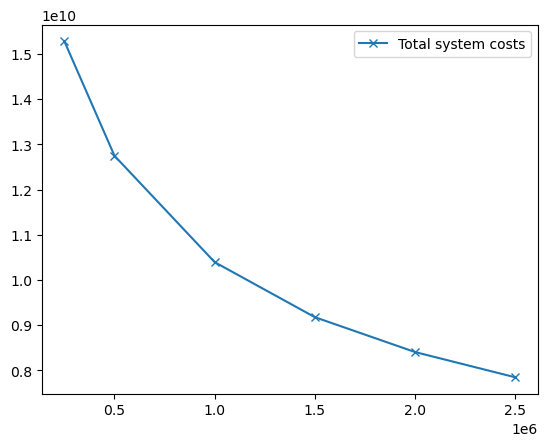

In [62]:
emission_costs.plot(marker="x")